In [32]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.experimental import PeepholeLSTMCell
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [25]:
def preprocessing(df,parameters):

    df["isweekend"] = (df.datetime.dt.weekday > 5).astype(int)
    df["dayofweek"] = df.datetime.dt.weekday + 1
    # df["month"] = df.datetime.dt.month
    df["hour"] = df.datetime.dt.hour

    dfRaw = df[["datetime","values","isweekend"]]
    
    for i in range(1,8):
        dfRaw["dayofweek_" + str(i)] = 1*(df["dayofweek"] == i).values

    # for i in range(1,13):
    #     dfRaw["month_" + str(i)] = 1*(df["month"] == i).values

    for i in range(24):
        dfRaw["hour_" + str(i)] = 1*(df["hour"] == i).values

    ### training    
    cleanDf_scaled = dfRaw.drop(columns="datetime")
    ## 
    
    return dfRaw

def create_dataset(dataset, step, output_size):
    dataX, dataY = [], []
    for i in range(len(dataset)-step-output_size):
        out_end = i + step + output_size
        if(out_end <= len(dataset)):
            a = dataset[i:(i+step)]
            dataX.append(a)
            dataY.append(dataset[i + step:out_end])
    return np.array(dataX), np.array(dataY)

#Get previously saved model
def get_model(tenant,point,*args):
    model_path = variables.path_to_models + "/" + tenant + "/" + point + ".h5"
    model = load_model(model_path)
    return model

#Iterative multi step forecast
def forecast(model,dfRaw,forecastRange,parameters):
    scalers = {}
    df_scaled = dfRaw.set_index("datetime")
    for col in df_scaled.columns:
        scalers[col] = MinMaxScaler(feature_range=(0, 1))
        df_scaled[col] = scalers[col].fit_transform(df_scaled[col].values.reshape(-1,1))
    

    for i in range(forecastRange):
        #Preparing input
        input_CashIn = df_scaled.tail(parameters["lookBack"]).values.reshape(1, parameters["lookBack"], df_scaled.shape[1])
        # Forecast Result
        res = model.predict(input_CashIn)[0][0]
        #Adding new result to the dataframe
        new_index = df_scaled.index[-1] + timedelta(hours=1)
        row = np.zeros(df_scaled.shape[1])
        row[0] = res
        df_scaled.loc[new_index] = row
        df_scaled.at[new_index,"dayofweek_" + str(new_index.dayofweek+1)] = 1.0
        df_scaled.at[new_index,"hour_" + str(new_index.hour)] = 1.0
        # df_scaled.at[new_index,"day_" + str(new_index.day)] = 1.0

    df_forecast = pd.DataFrame({
        "datetime" : df_scaled.tail(forecastRange).index,
        "value" : scalers["values"].inverse_transform(df_scaled.tail(forecastRange)["values"].values.reshape(-1,1)).reshape(1,-1)[0],
        "definition" : "activeEnergy",
        "variant" : "import",
        "type" : "predicted",
        "note" : None,
        }
    )
    return df_forecast

### ERROR METRICS
def RMSE(df):
    actuals = df["actual"].values
    predicted = df["predicted"].values
    error = actuals-predicted
    return math.sqrt(np.mean(np.square(error)))

def MAE(df):
    actuals = df["actual"].values
    predicted = df["predicted"].values
    error = actuals-predicted
    return np.mean(abs(error))

def MAPE(df):
    actuals = df["actual"].values
    predicted = df["predicted"].values
    error = actuals-predicted
    return np.mean(np.abs(error/actuals*100))

def MSE(df):
    actuals = df["actual"].values
    predicted = df["predicted"].values
    error = actuals-predicted
    return np.mean(np.square(error))

def NRMSE(df):
    actuals = df["actual"].values
    predicted = df["predicted"].values
    error = actuals-predicted

    # norm_tech = np.std(actuals) #standard deviation
    # norm_tech = np.subtract(*np.percentile(actuals, [75, 25])) #iqr
    norm_tech = np.subtract(np.amax(actuals),np.amin(actuals)) #max-min
    return RMSE(df)/norm_tech


In [4]:
df = pd.read_csv("data/generation.csv", delimiter=";").dropna()
df["DateTime"] = pd.to_datetime(df["DateTime"],format="%d%b%Y %H:%M:%S")
df["Generation"] = df["Generation"].str.replace(",",".").astype("float")

In [57]:
scalers = {}
df_scaled = df.set_index("DateTime")
for col in df_scaled.columns:
    scalers[col] = MinMaxScaler(feature_range=(0, 1))
    df_scaled[col] = scalers[col].fit_transform(df_scaled[col].values.reshape(-1,1))    

trainX, trainY = create_dataset(df.drop(columns="DateTime").values,168,1)

In [84]:
trainX[0].shape

(168, 1)

In [60]:
params = {
    'lookBack': 7*24,
    'outputSize': 1,
    'learningRate': 0.001,
    'epochs': 50,
    'regularizationCoeff': 0.001,
    'batchSize': 128,
}
parameters = {
    "parameters" : params,
    'num_features' : 1
    
}

model = Sequential()
model.add(LSTM(64, kernel_regularizer=l2(parameters["parameters"]["regularizationCoeff"]), input_shape=(parameters["parameters"]["lookBack"], parameters["num_features"]), name="LSTM-1"))
model.add(Dense(parameters["parameters"]["outputSize"], activation='relu', name="Output"))
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))   

model.fit(
    trainX, 
    trainY,
    epochs=parameters["parameters"]["epochs"],
    batch_size = 128,
    verbose=1,#Iterative multi step forecast
    )
loss = model.history.history["loss"]

Epoch 1/50


2022-02-17 13:30:54.910510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-17 13:30:54.981632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-17 13:30:55.325957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 15s 68ms/step - loss: 21526.5918
Epoch 2/50
199/199 [==============================] - 13s 67ms/step - loss: 18852.1992
Epoch 3/50
199/199 [==============================] - 13s 65ms/step - loss: 17031.7129
Epoch 4/50
199/199 [==============================] - 13s 64ms/step - loss: 15434.0312
Epoch 5/50
199/199 [==============================] - 12s 62ms/step - loss: 13999.9180
Epoch 6/50
199/199 [==============================] - 13s 63ms/step - loss: 12705.6768
Epoch 7/50
199/199 [==============================] - 12s 62ms/step - loss: 11528.5938
Epoch 8/50
199/199 [==============================] - 12s 62ms/step - loss: 10455.4463
Epoch 9/50
199/199 [==============================] - 13s 64ms/step - loss: 9476.5244
Epoch 10/50
199/199 [==============================] - 13s 64ms/step - loss: 8583.6699
Epoch 11/50
199/199 [==============================] - 13s 66ms/step - loss: 7770.0503
Epoch 12/50
199/199 [==============================] - 

In [64]:
predictions = []
for i in range(24):
    predicted = model.predict(trainX[i].reshape(1, 168, 1))[0][0]
    predictions.append(predicted)

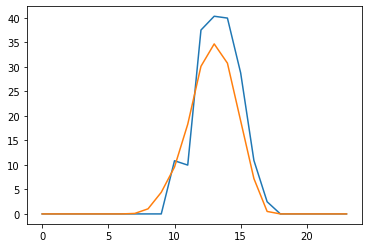

In [80]:
predictions

plt.plot(predictions)
plt.plot(trainY.reshape(1,25391)[0,0:24])
plt.show()

In [79]:
trainY.reshape(1,25391)[0,0:24]

array([0.00000000e+00, 8.00000000e-06, 0.00000000e+00, 8.00000000e-06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.92239000e-02,
       1.03568560e+00, 4.40496160e+00, 9.54539010e+00, 1.82795409e+01,
       3.00926382e+01, 3.46551037e+01, 3.07275152e+01, 1.89674106e+01,
       7.20832020e+00, 5.03350300e-01, 0.00000000e+00, 8.00000000e-06,
       0.00000000e+00, 0.00000000e+00, 8.00000000e-06, 0.00000000e+00])

31.432195064691435


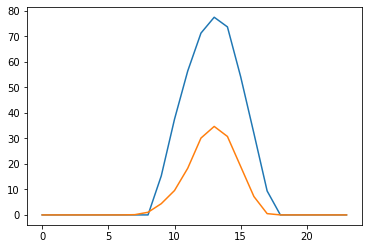

30.69679320095431


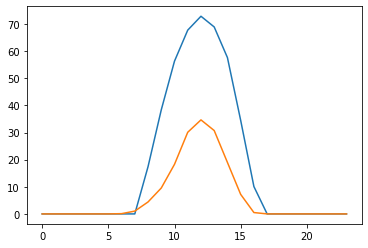

30.515785885895575


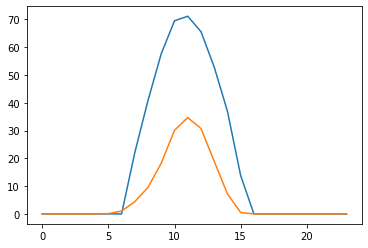

29.510484961813077


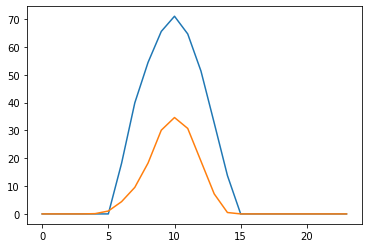

27.0648854457274


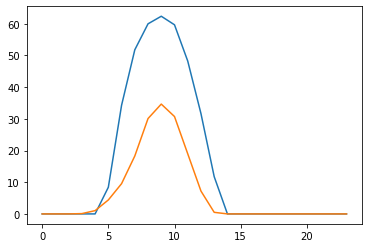

26.52763079459422


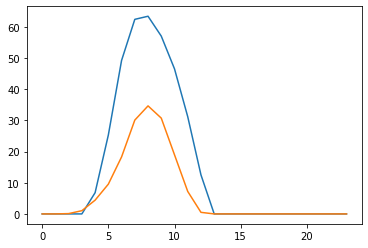

25.208511835991576


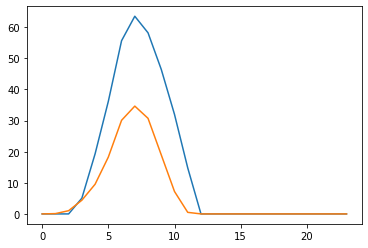

21.46773797979092


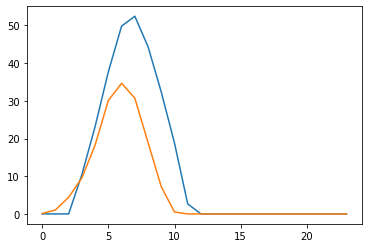

16.299349208617375


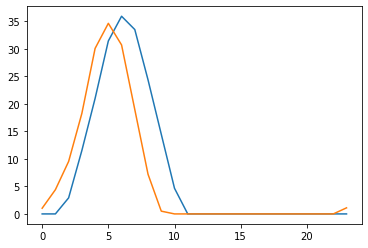

13.357116983692197


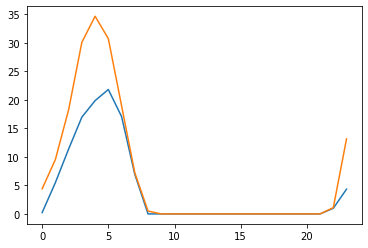

17.919788582024072


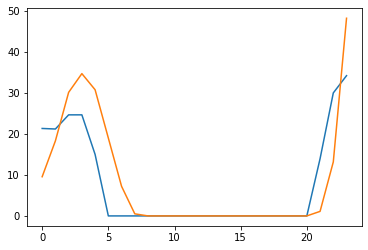

25.567385993035117


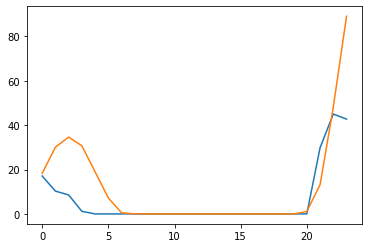

39.510615754553235


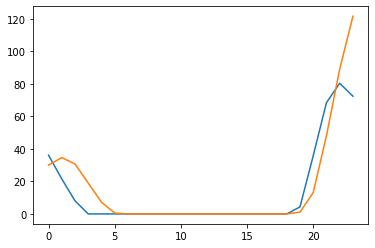

55.1776820433983


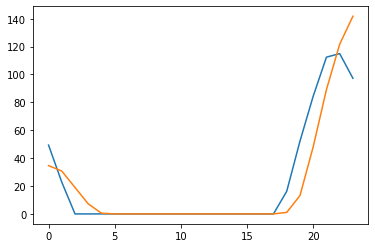

68.56120545269518


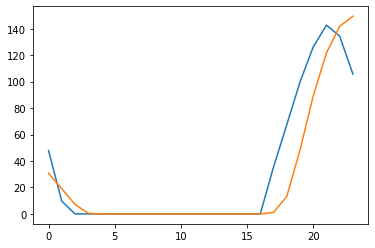

82.28580370251107


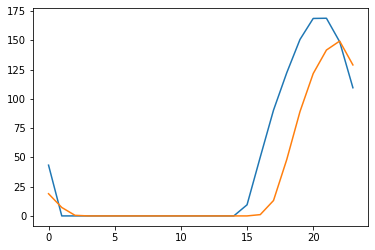

86.7921739513045


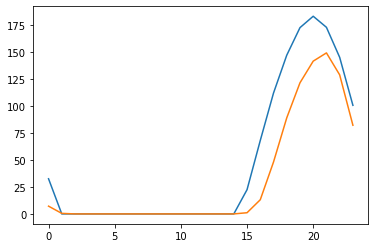

80.58207255701649


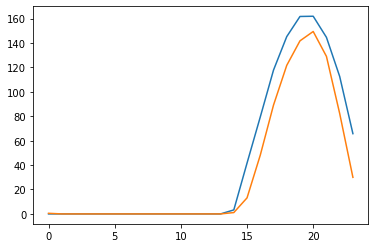

66.57951462772192


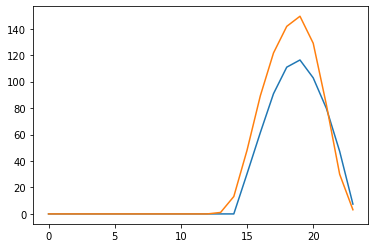

65.12589165537118


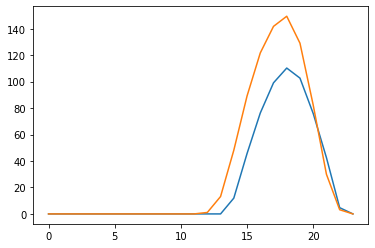

64.23160164270027


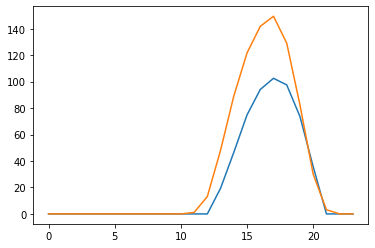

64.19308061543443


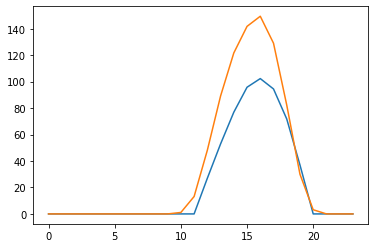

62.54338550348887


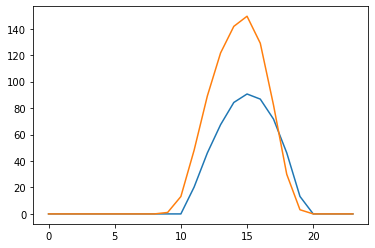

63.78821889735675


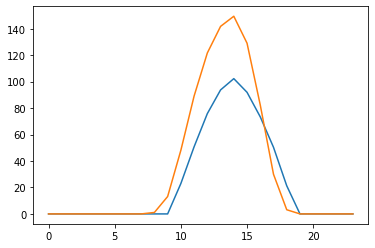

64.90599030156145


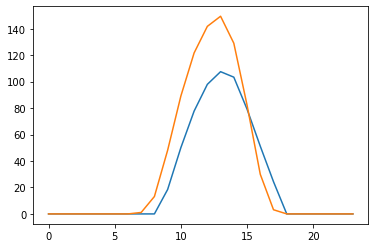

65.81053163341268


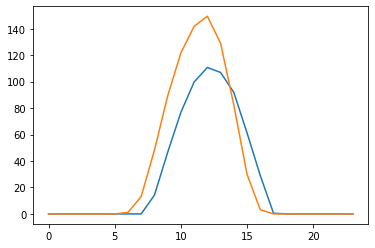

67.08805358818793


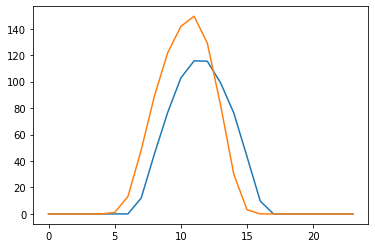

66.47044877267894


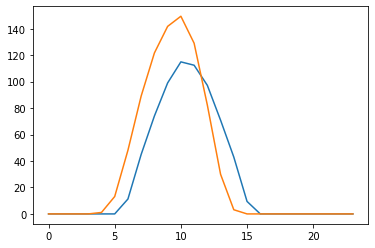

64.04115103210938


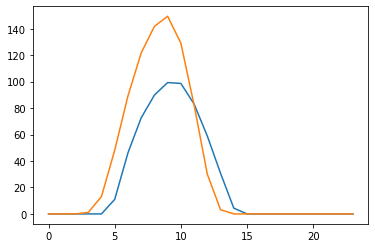

62.78381290298393


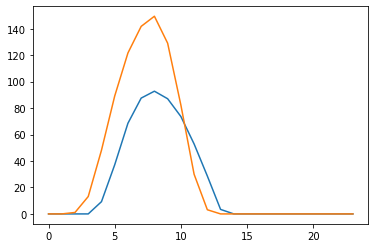

62.177956055260886


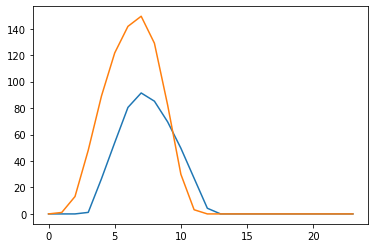

61.159686651920495


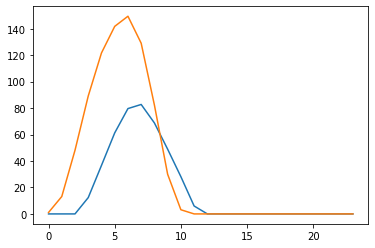

59.82316694690013


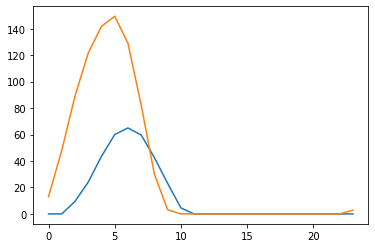

59.322481604588475


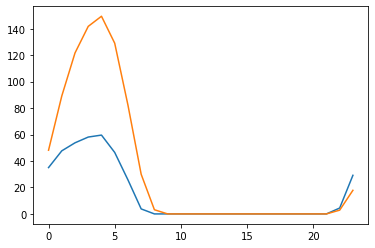

62.718163531897275


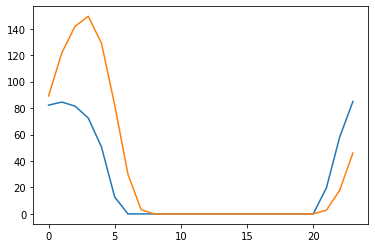

63.68161854864103


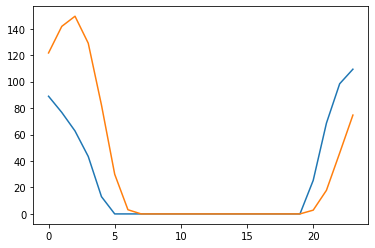

69.93629345761543


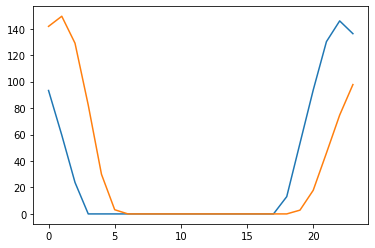

81.49825328068265


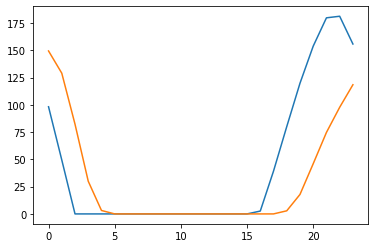

97.96498645290905


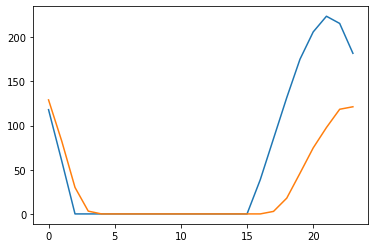

116.23734199464838


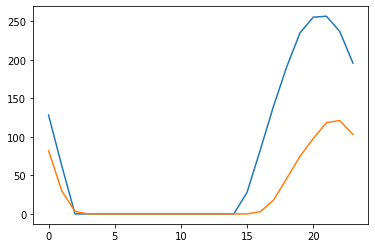

127.20098263629606


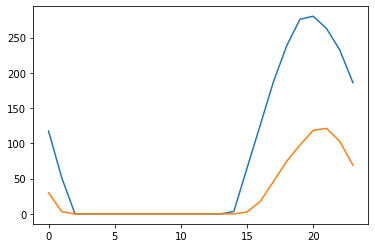

127.18373102827394


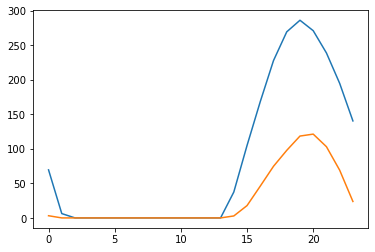

125.45485959738961


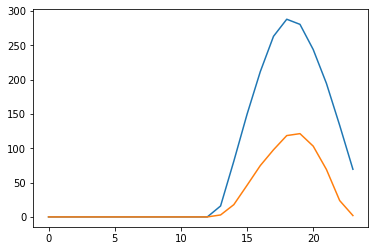

110.78874383249556


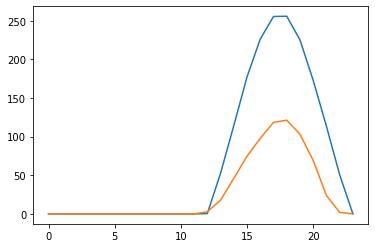

105.95517927842639


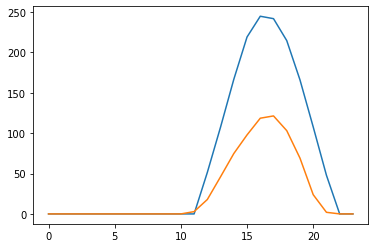

108.43158857348345


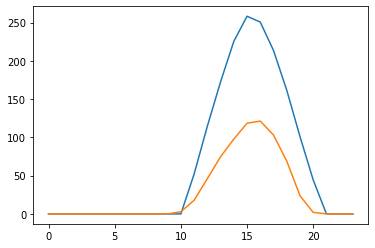

111.97604757003893


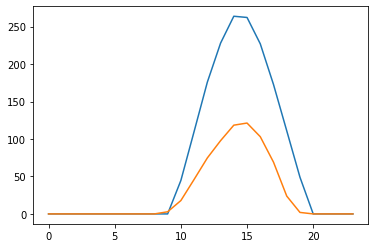

114.1669600869349


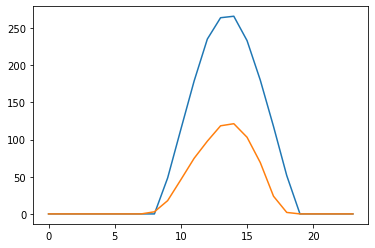

113.34233966920041


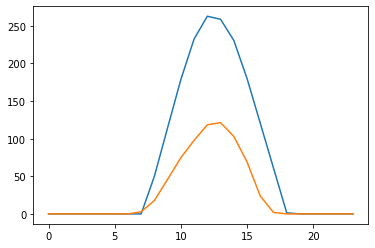

113.60300582786108


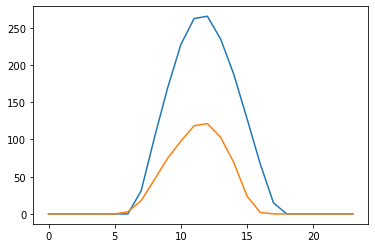

116.75091784861222


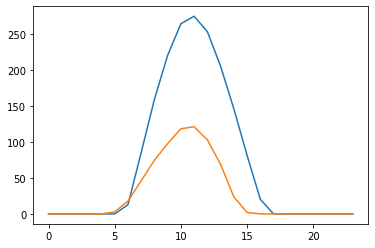

119.23644849796713


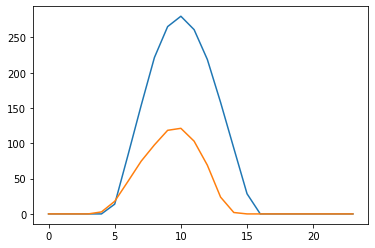

121.79481915806613


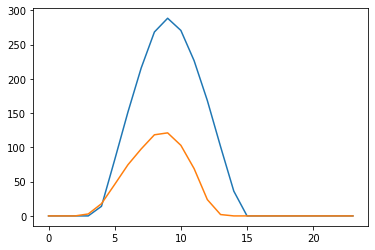

120.61924037147041


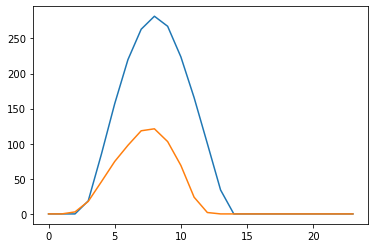

114.46673592980552


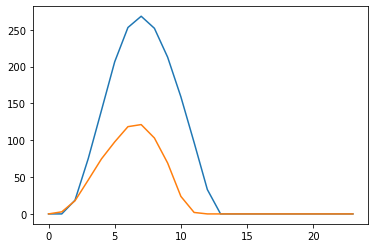

85.90218389826043


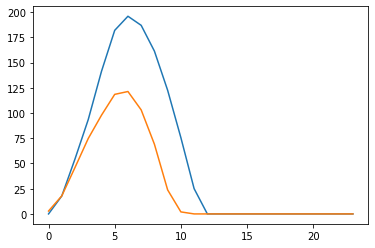

80.8059996673997


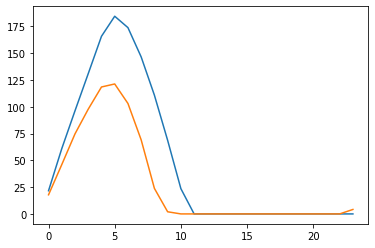

88.76755729205803


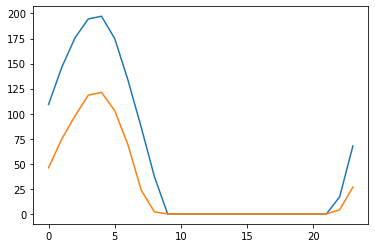

82.65683215396078


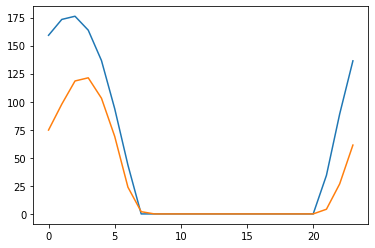

83.43330645136295


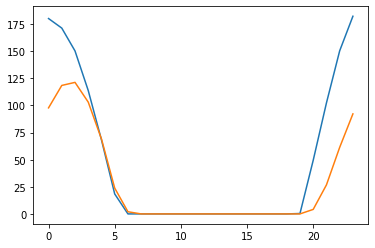

88.95969831019433


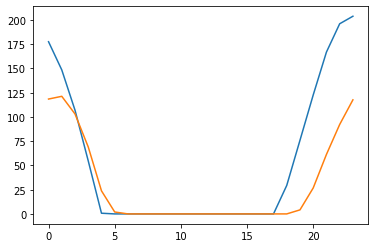

94.96398935877815


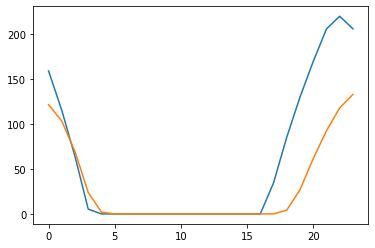

104.58677574179588


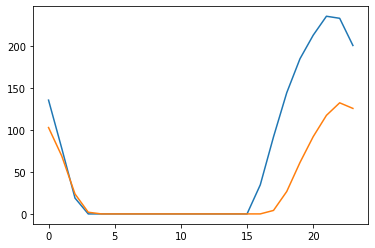

112.72431912980056


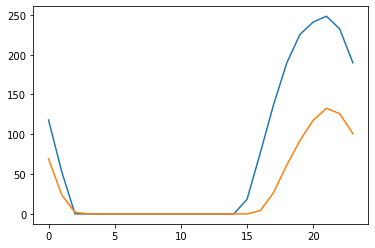

117.88891042795184


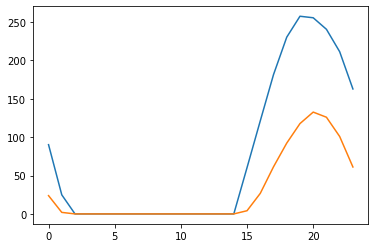

121.4140250902293


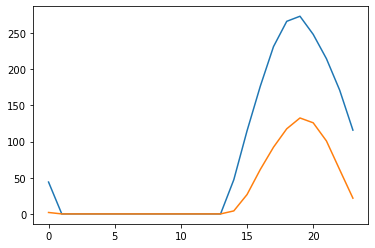

120.62095514185826


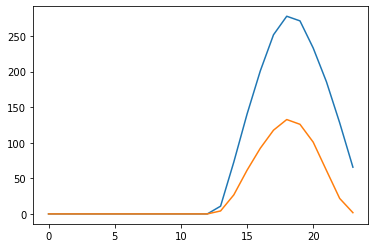

113.7695387954361


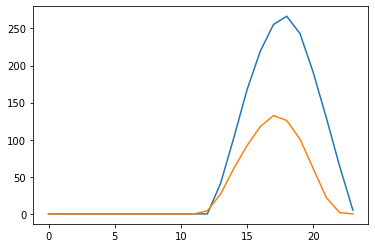

111.15885997022534


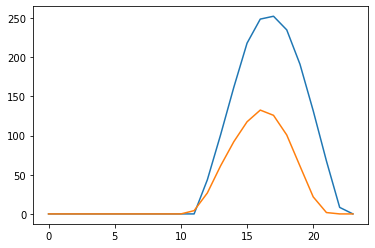

114.56747982758073


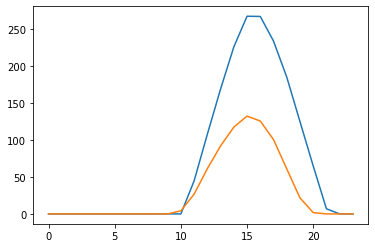

115.3632144262161


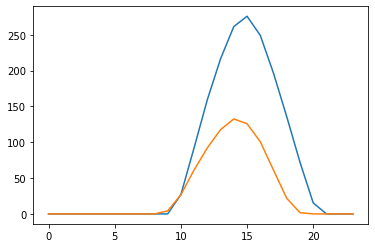

115.59669240554607


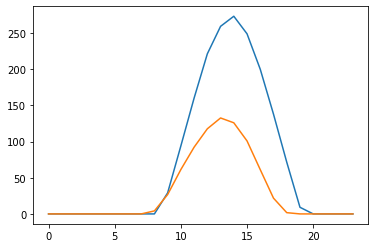

116.44271551906891


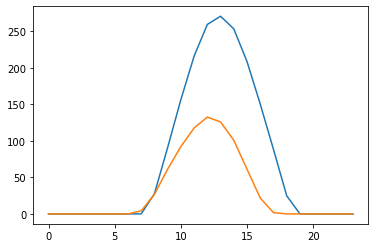

118.88094877216169


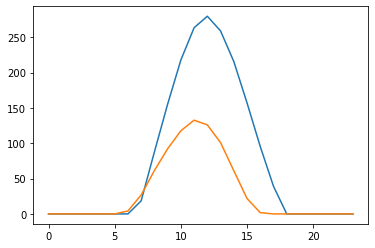

120.43264197894698


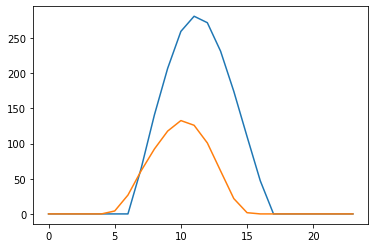

118.12887385433851


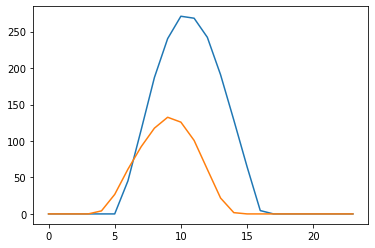

115.95296967600105


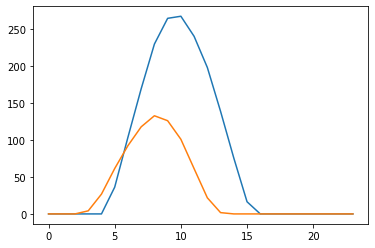

114.7064353272127


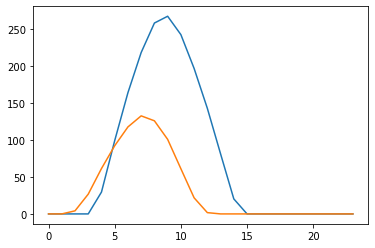

110.89783076645104


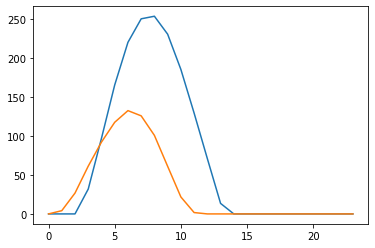

98.98892316413549


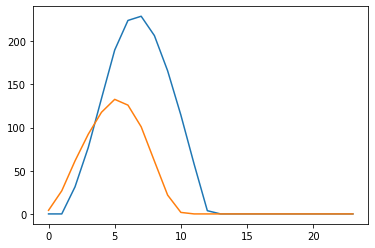

96.4654706933884


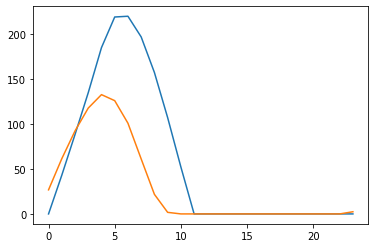

103.45885852280747


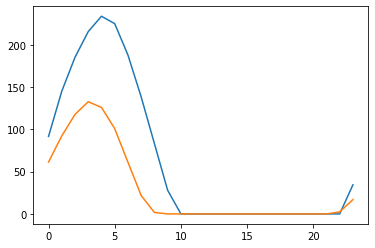

98.88477147234444


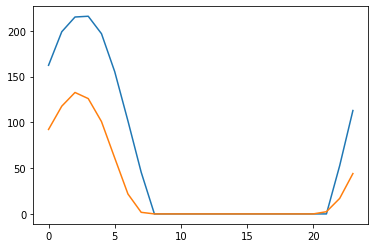

93.79855617004998


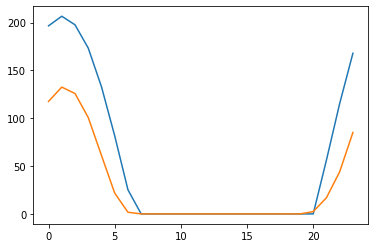

91.90634539648562


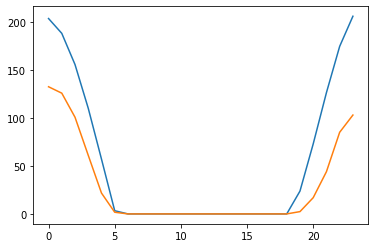

95.98515803370239


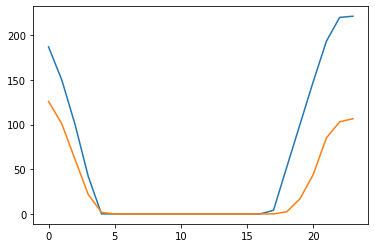

105.43139488361963


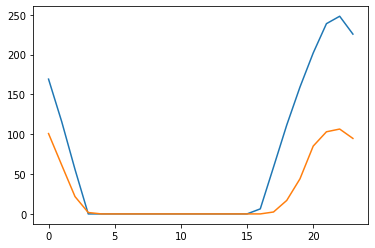

113.20807323528726


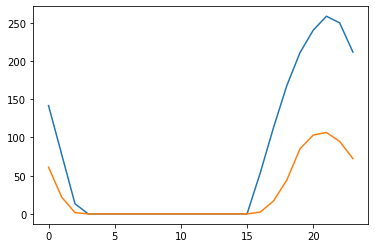

116.64927141216208


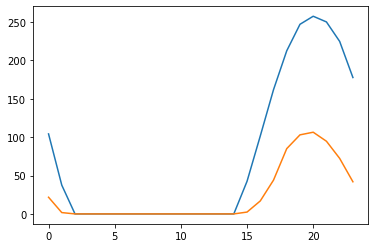

111.93209904005981


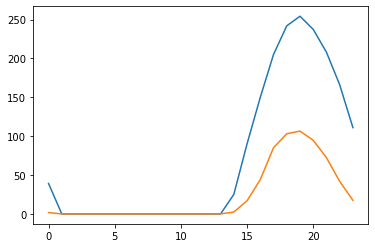

103.19271480371944


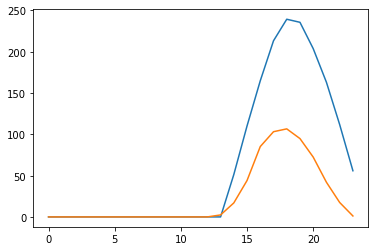

99.36226470361535


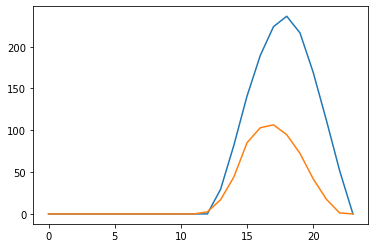

102.32646146196159


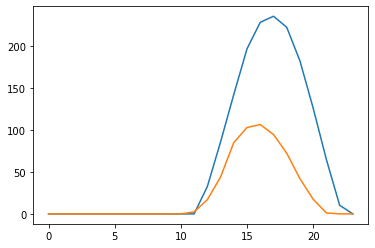

106.77976566600223


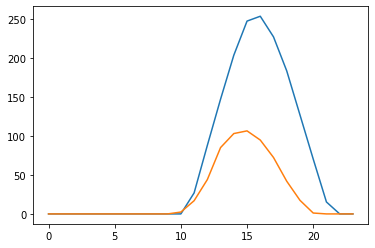

110.067413926538


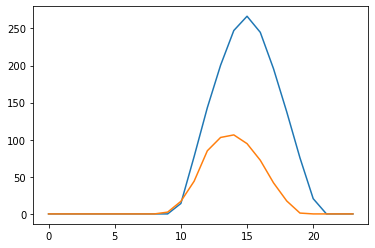

113.413590809576


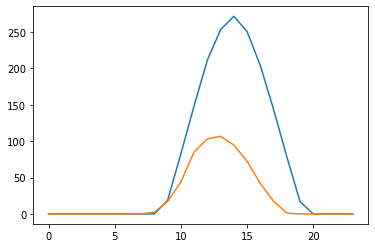

115.84669405013997


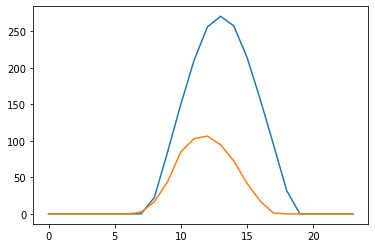

119.05780003701686


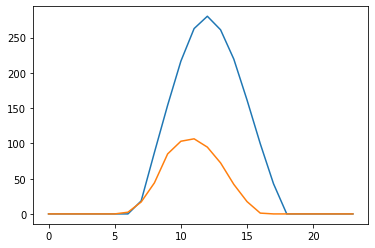

119.30634376461325


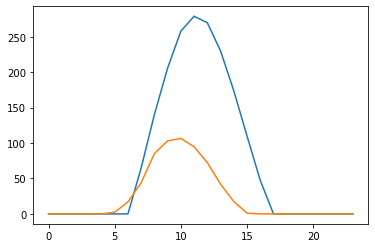

117.0538592358721


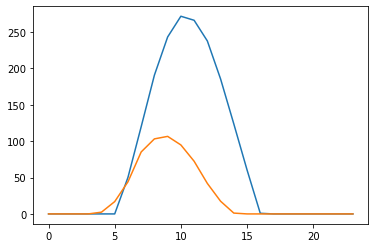

115.30790369522032


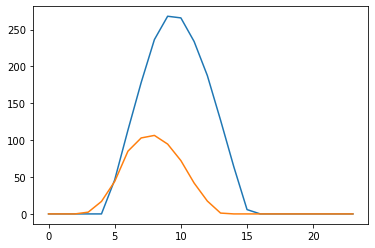

112.98660637199094


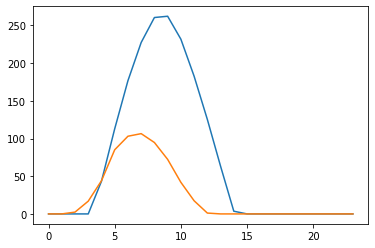

110.43918621035895


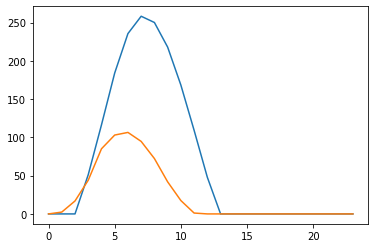

101.9806417138541


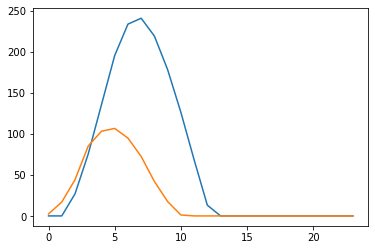

84.65623587768142


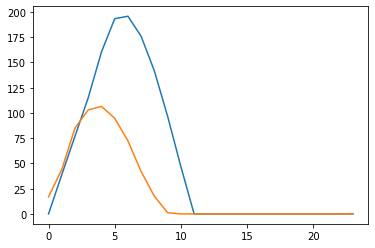

100.96536183992075


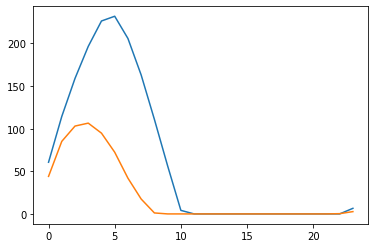

96.5061397854547


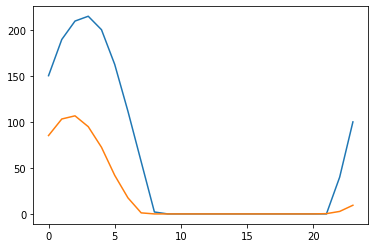

86.5184513092002


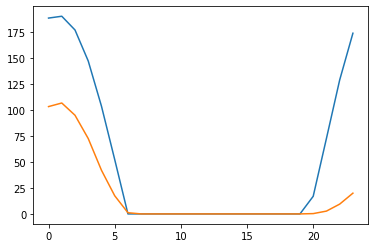

85.06037860974003


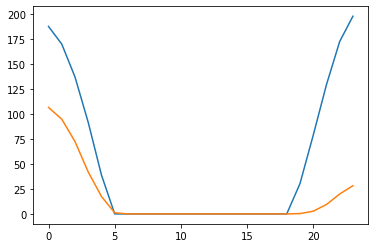

90.47870375335836


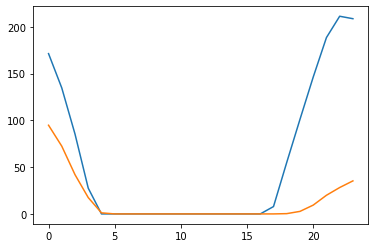

99.93288861464566


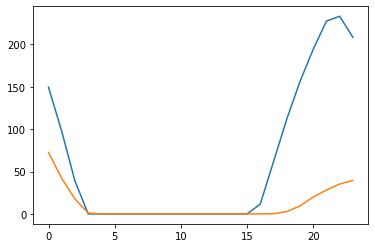

108.5016197678851


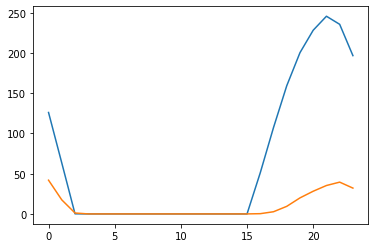

111.3060377272996


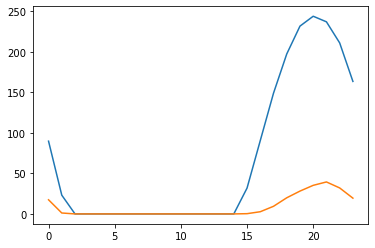

110.64079269031863


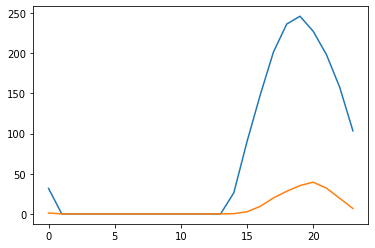

95.90249663798986


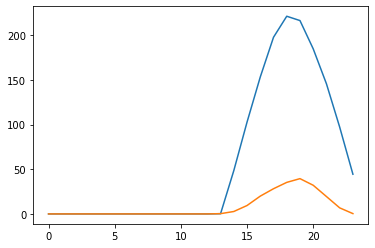

96.98014350284481


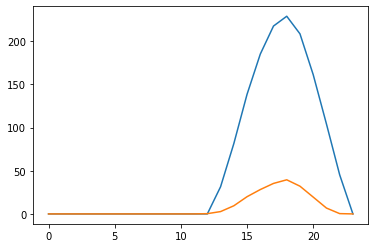

103.39976673552472


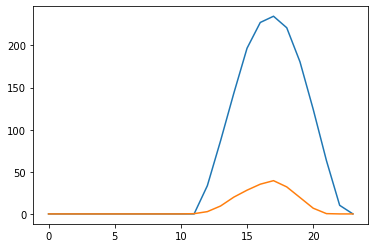

106.81270251281403


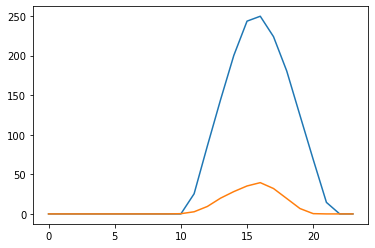

110.34615959473531


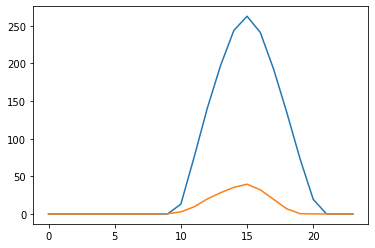

114.27169835768335


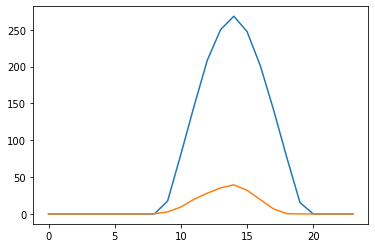

115.21177455481221


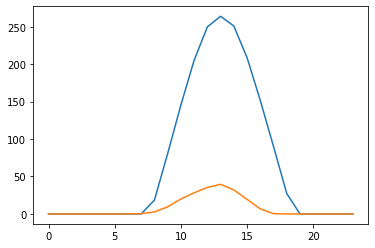

116.66995494414984


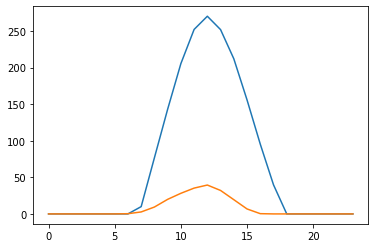

119.290857954475


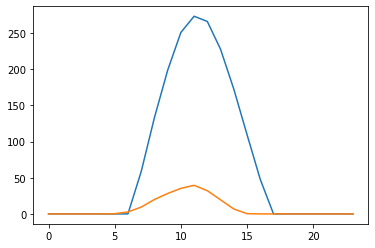

117.8241760804708


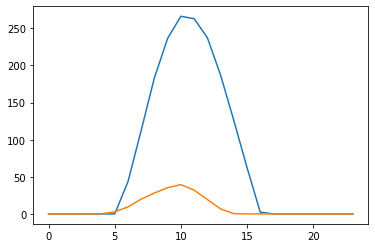

115.11249570465777


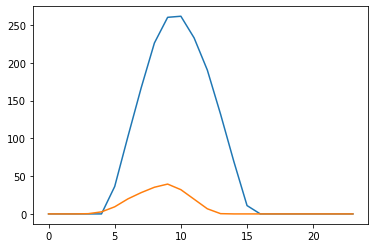

110.56421238469731


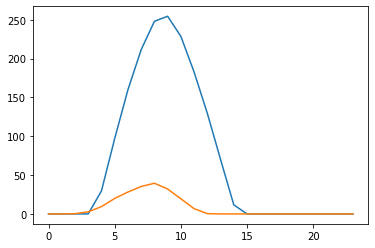

102.20894435713478


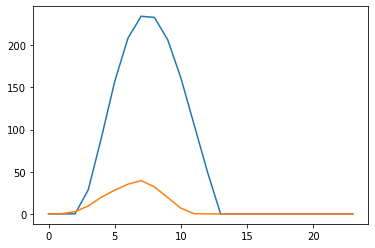

81.61708848012206


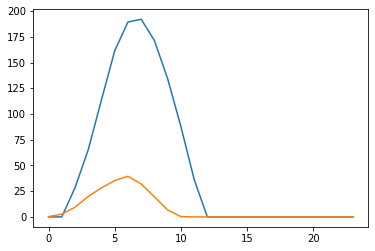

60.84643263866887


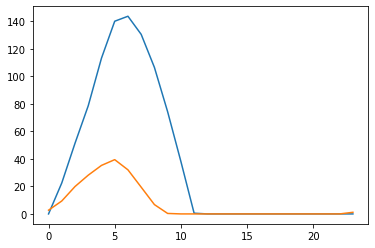

59.870605111466254


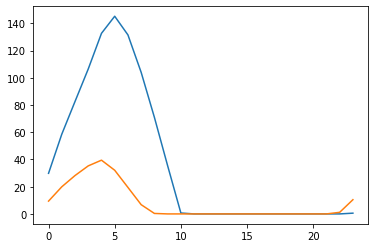

62.86577693194239


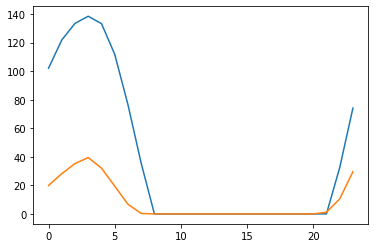

53.42342270020491


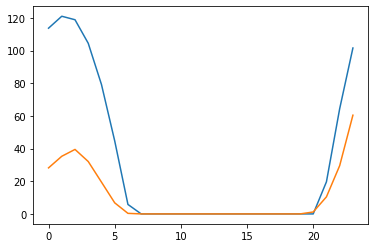

53.2079573580359


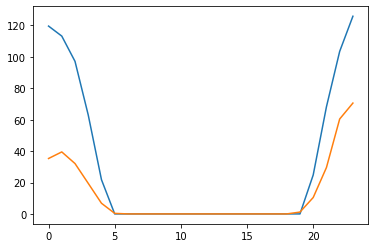

60.40648904581227


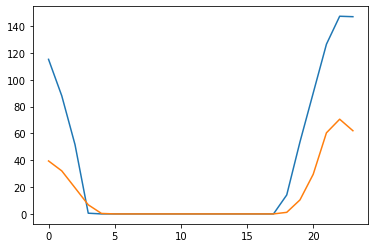

72.28201949927954


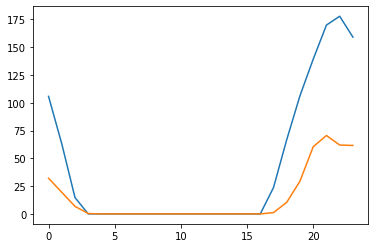

77.21788755725873


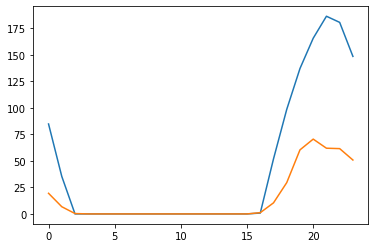

78.10300654856746


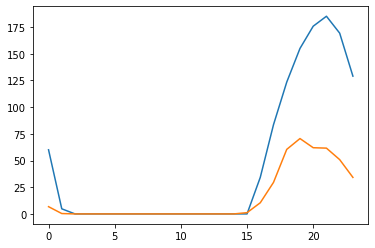

65.75573577839558


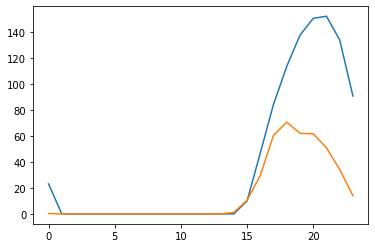

41.624047374156405


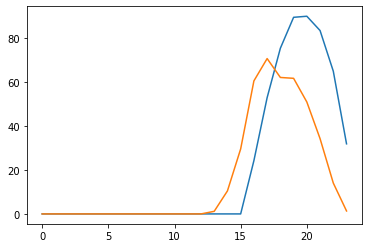

34.764555342078204


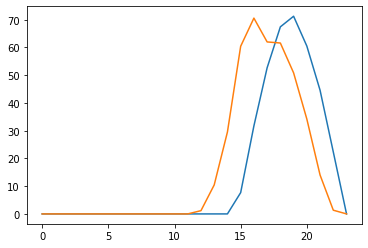

33.39928102352273


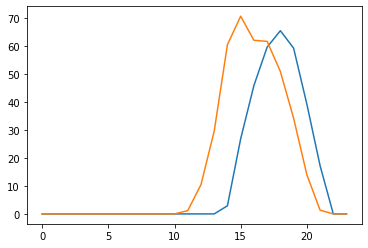

34.54656295899278


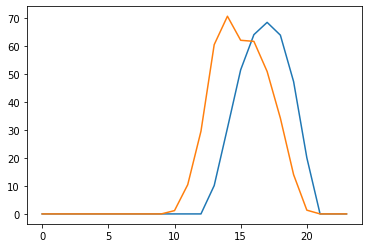

37.09693276813015


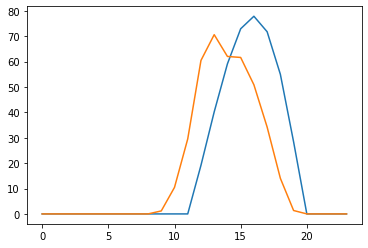

39.109147504880276


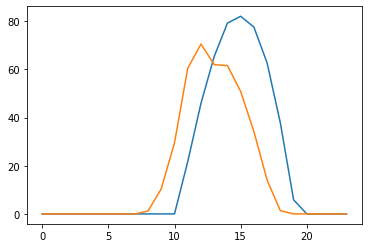

40.7318548809799


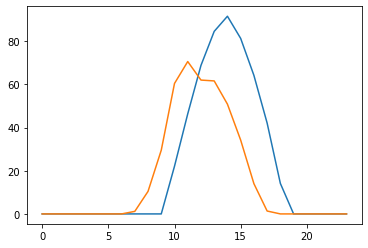

42.06344359386956


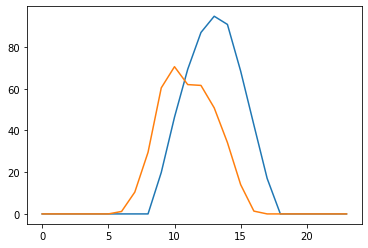

42.99154347215617


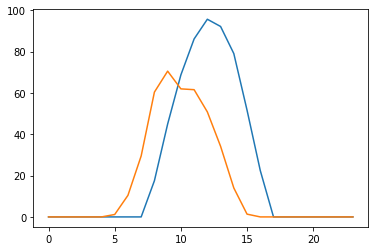

43.62462148399577


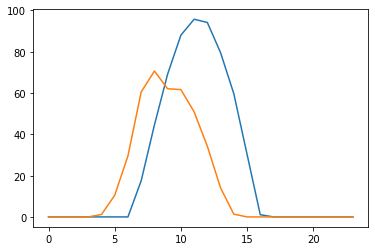

41.911775384941436


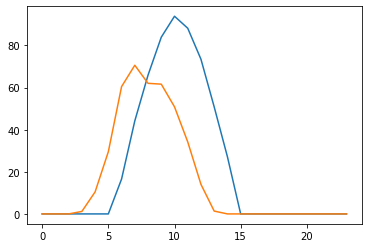

38.24870015413708


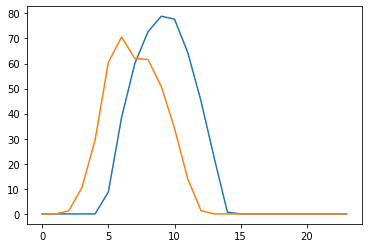

37.444456336352545


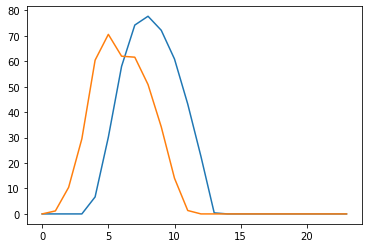

38.28847772030771


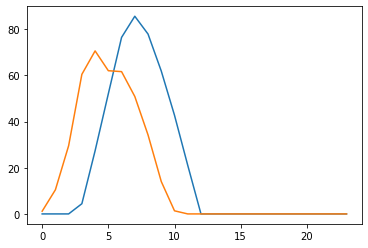

37.272267670401014


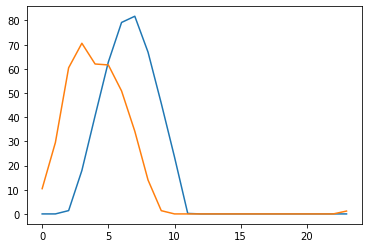

33.28407910060553


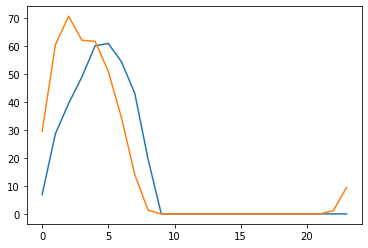

38.14338696214984


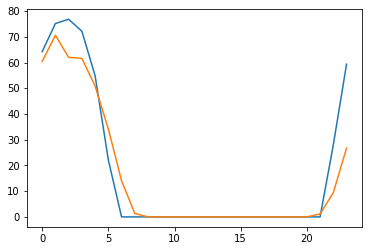

39.739159811111826


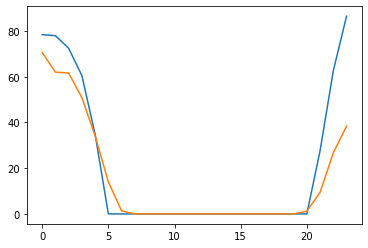

41.60811605649257


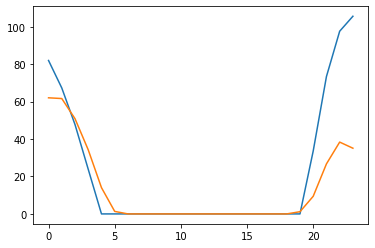

57.80482189232136


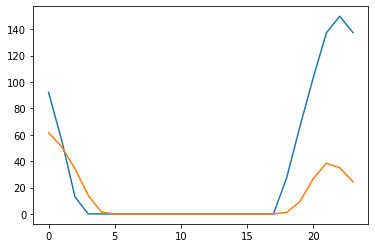

72.34182397610502


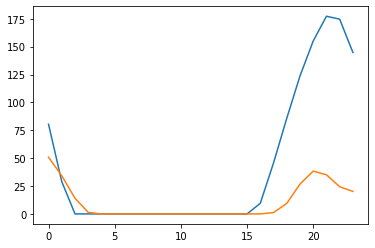

84.36249451145746


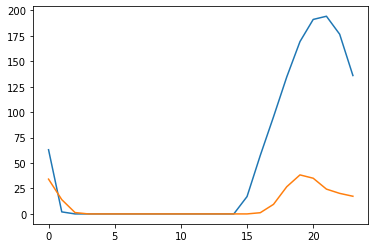

92.525853336617


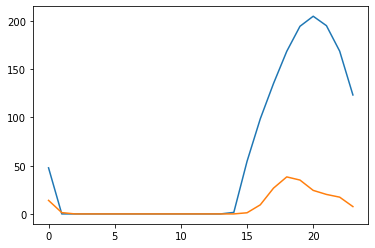

93.45790971949083


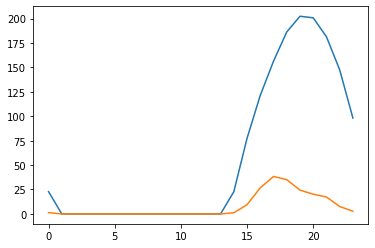

65.00821598963967


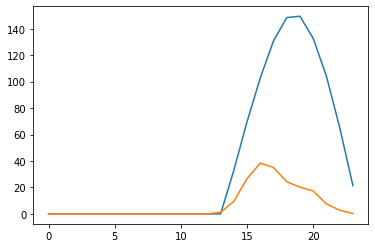

61.10085378615666


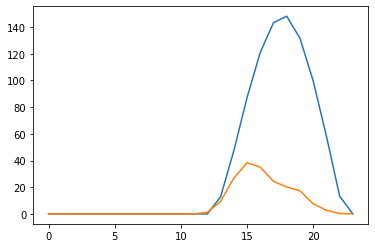

57.96085670010693


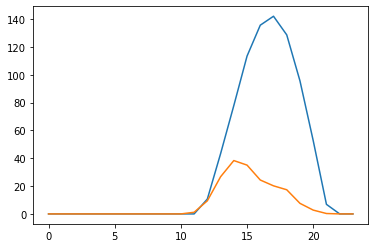

52.01507842778006


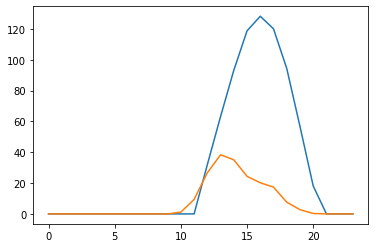

44.19876846395779


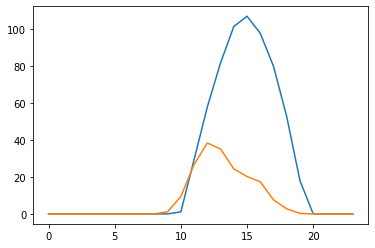

46.87205788089699


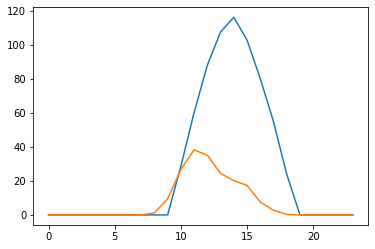

47.9539945564291


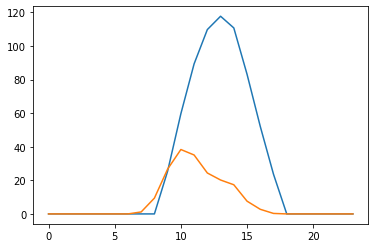

52.49046156154745


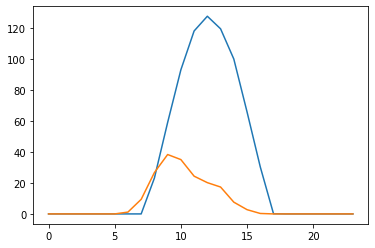

59.33243713035404


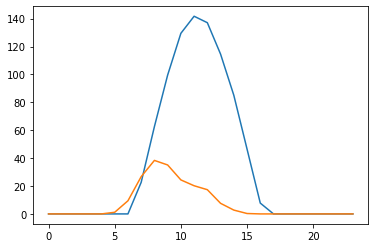

58.90912730694689


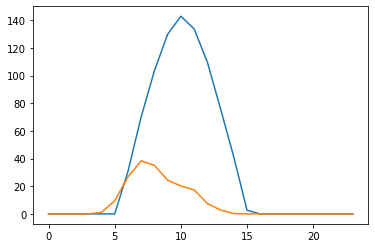

52.55401594552467


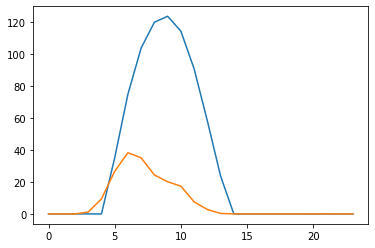

47.0842229487758


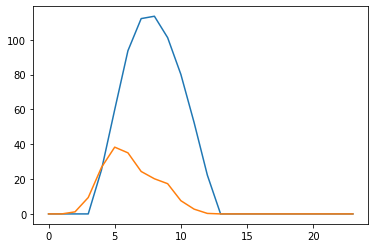

42.760067548222814


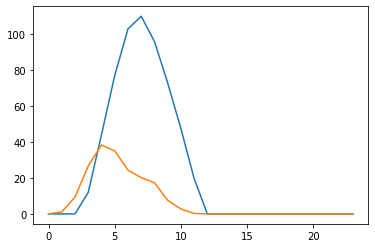

31.36539172587516


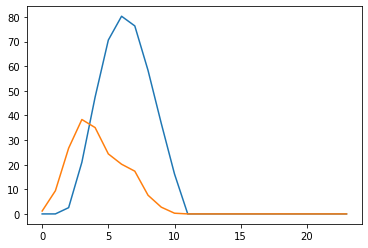

25.718410486177007


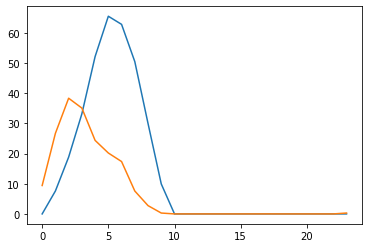

32.39558475985416


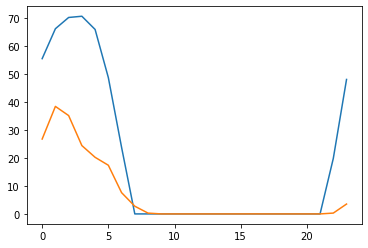

29.76523434878603


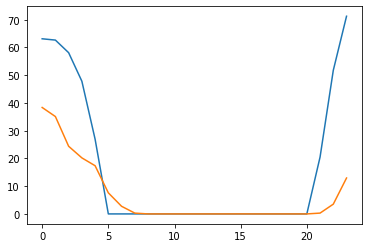

35.97310694314815


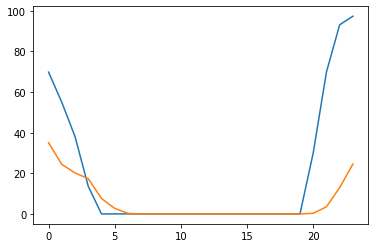

49.052899906170325


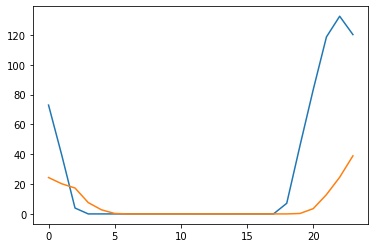

57.20516922903812


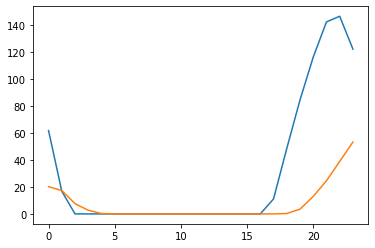

62.64087164314155


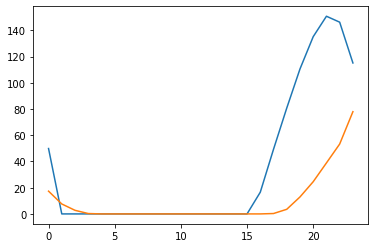

71.31859594727027


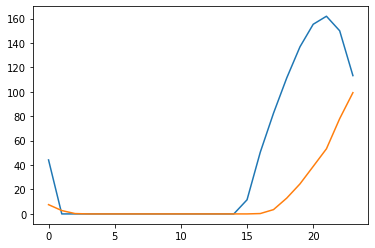

66.75241626770041


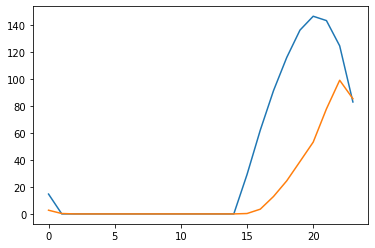

54.41382335335011


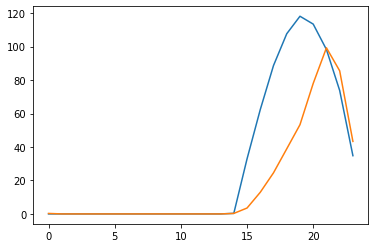

40.97028192819


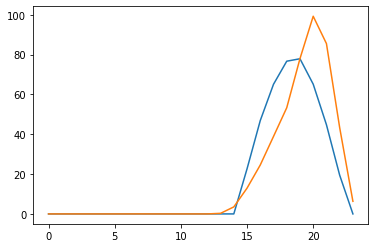

36.621940033460504


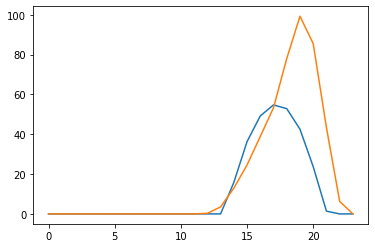

37.61153634218269


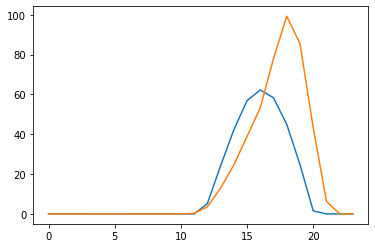

39.591824798079074


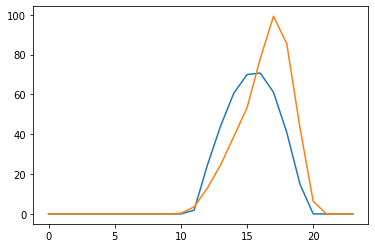

41.285428609739114


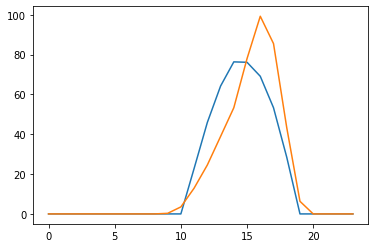

42.66217154443926


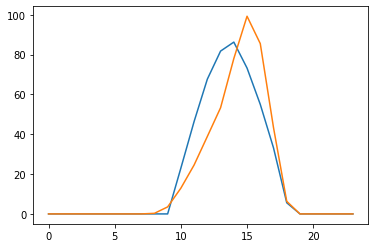

43.01277721686976


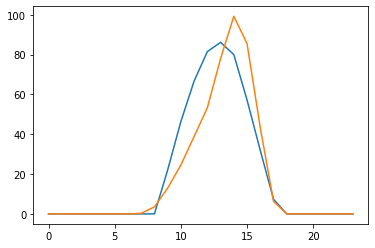

42.7433367290147


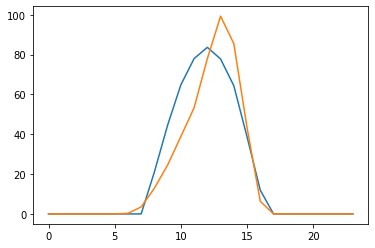

42.79069661226325


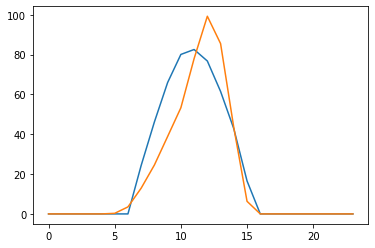

41.09618312985553


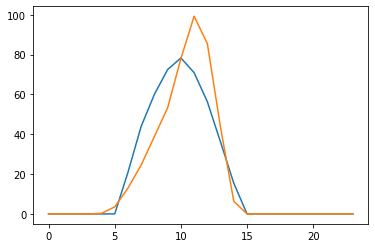

39.13693798677582


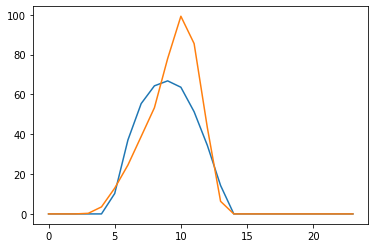

38.88459408431161


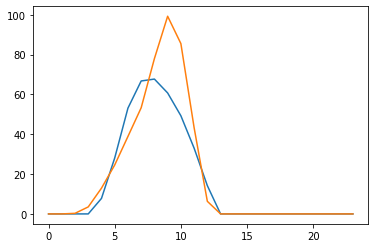

38.2893692194287


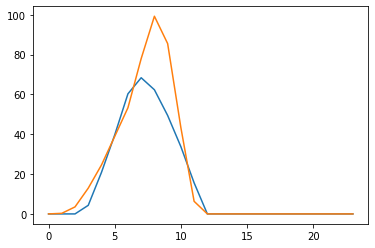

36.687484851592934


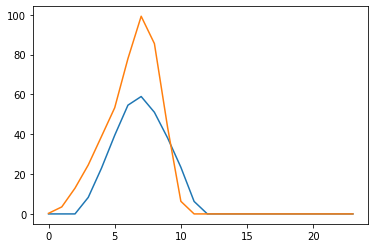

34.74635352853896


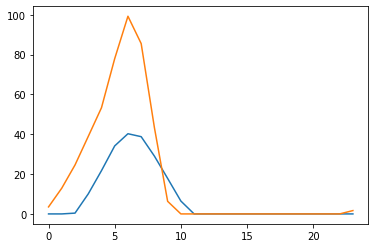

33.885791160594714


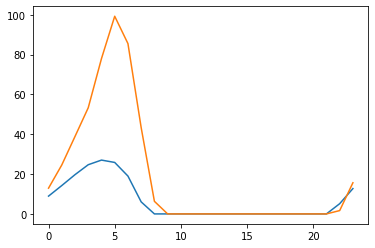

36.95020300940826


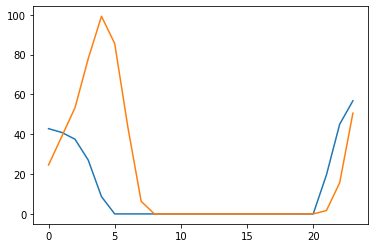

41.02215269924004


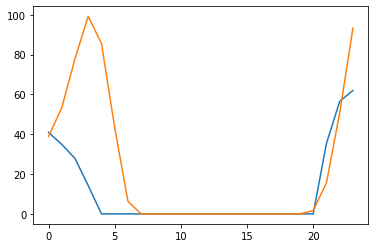

49.68223430871506


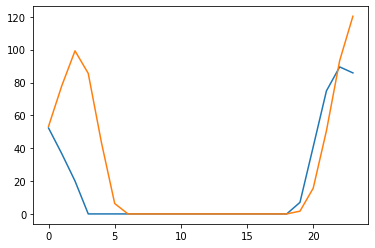

62.793153709783425


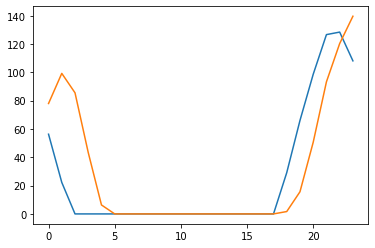

77.81813671263235


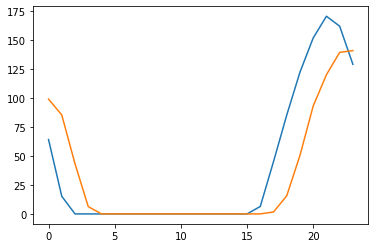

94.0358825606717


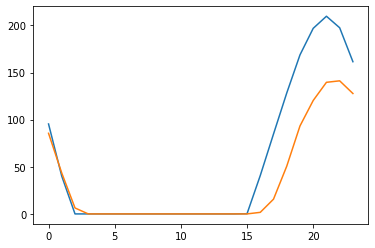

113.86044388996638


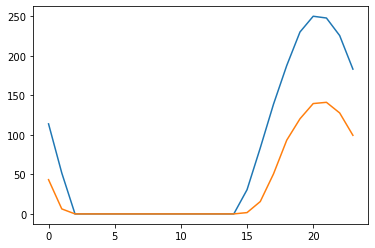

120.84519126581984


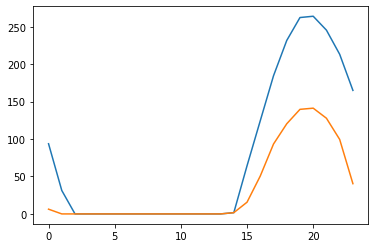

119.382415743871


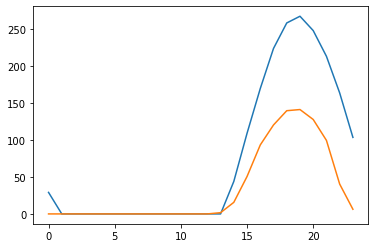

105.48184142058584


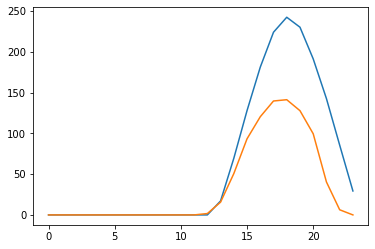

105.47090422736066


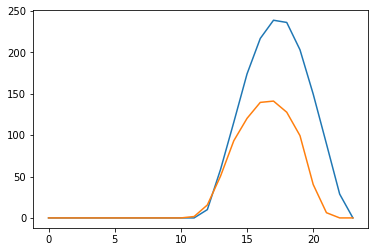

106.85347913470446


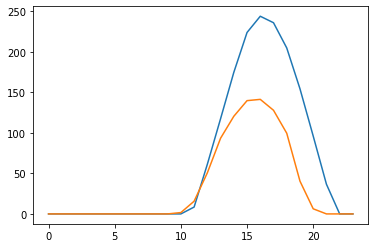

109.007753998581


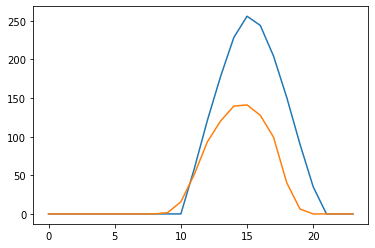

113.35399776624949


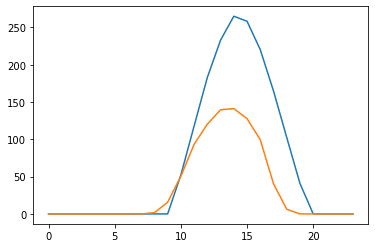

114.64724894030317


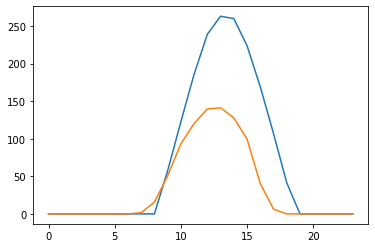

113.36573887401138


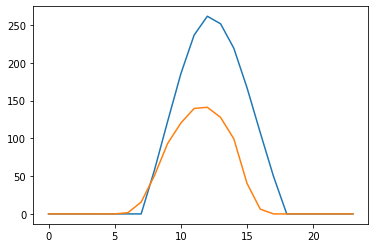

113.07151831660376


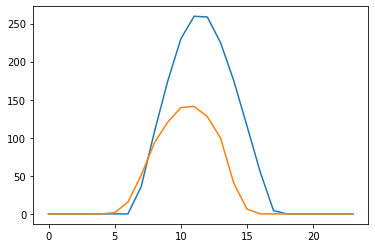

113.2294222095592


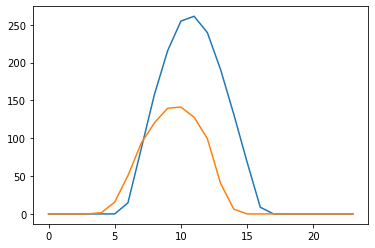

116.01007136901033


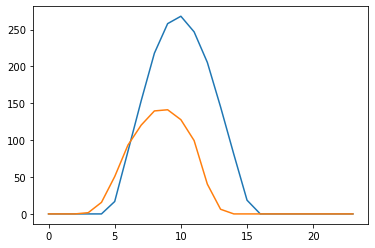

120.23379396312727


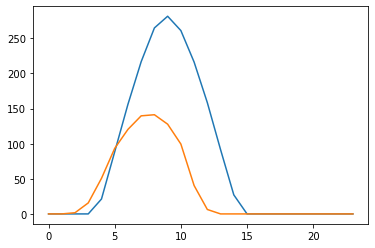

120.61544860816049


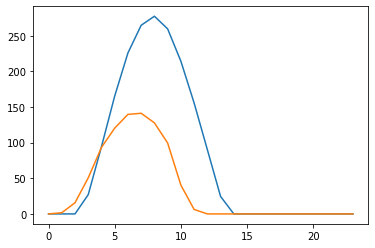

109.77642344567225


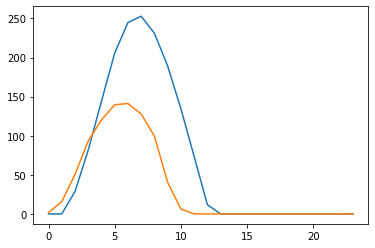

94.38245456096863


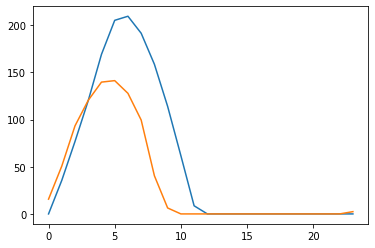

105.31766533042504


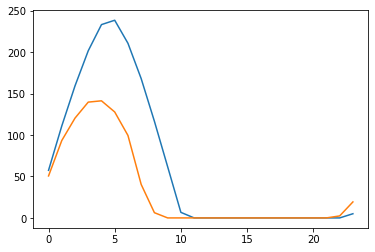

99.89587799180308


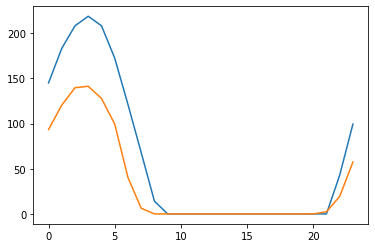

95.03870492744022


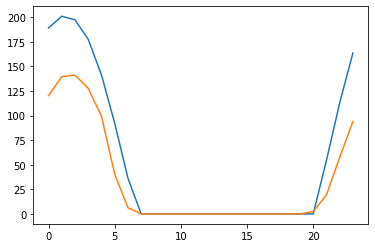

97.80655493262023


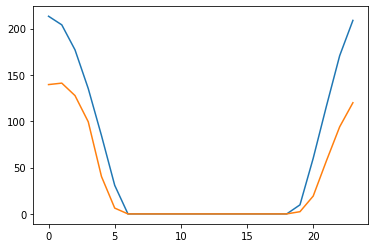

101.13235984513794


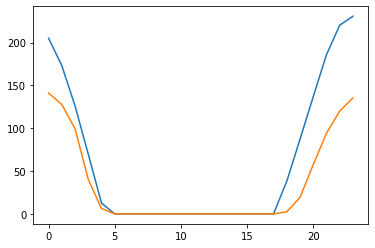

108.3230690089004


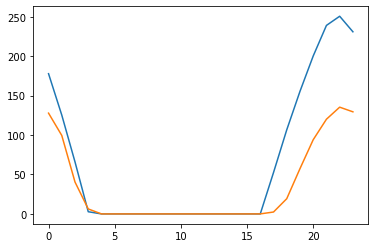

114.8489082906575


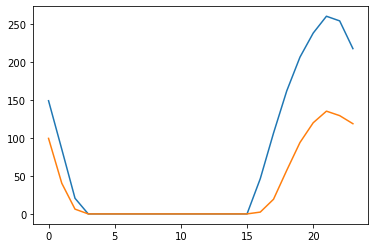

119.6362921056198


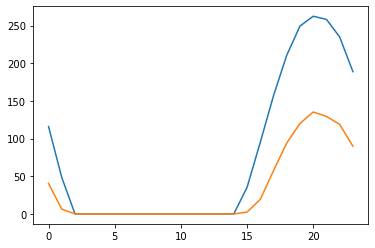

119.08881614909795


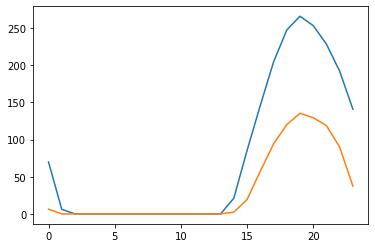

119.84815184183242


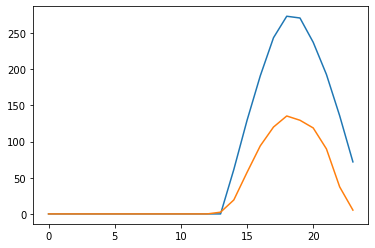

103.93998369395474


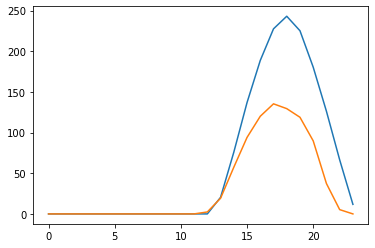

99.88835995958833


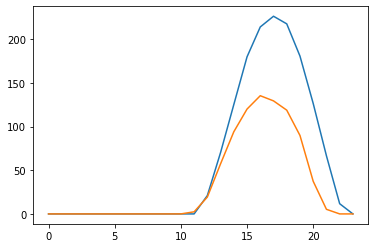

102.90196616014924


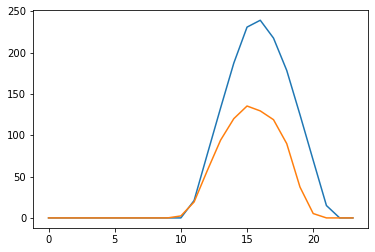

107.73413162443306


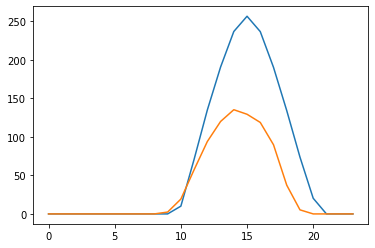

112.56049839084746


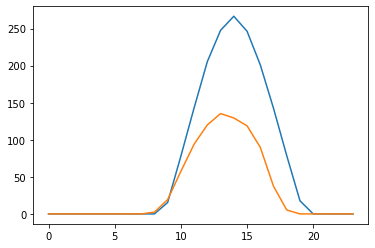

115.16899692546191


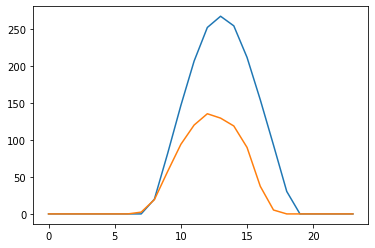

117.4398560451168


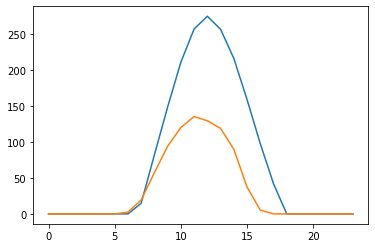

117.71151042234636


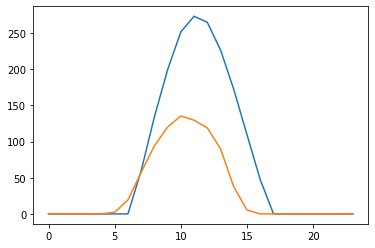

116.53889563094427


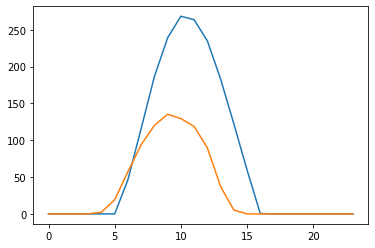

116.34197853368512


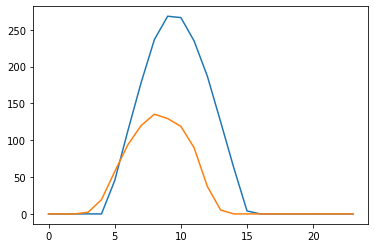

116.45228762796904


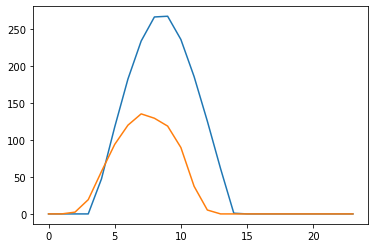

114.4706617743856


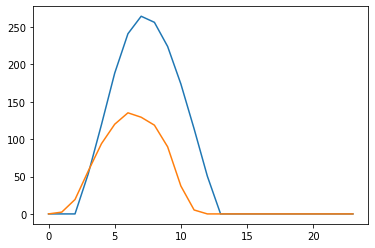

93.05869889492098


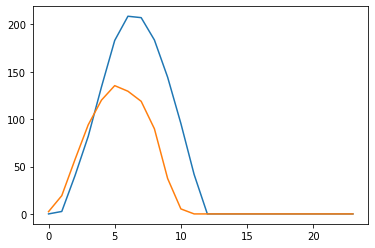

85.81379896632212


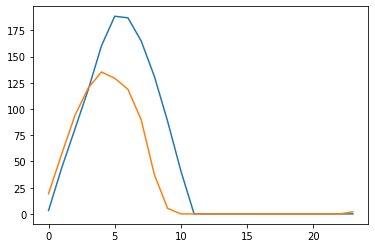

94.41414628625765


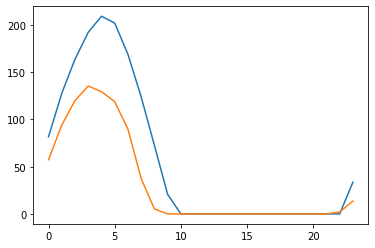

88.51767176214582


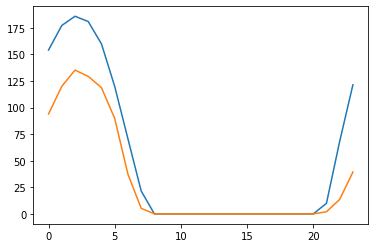

88.613415659945


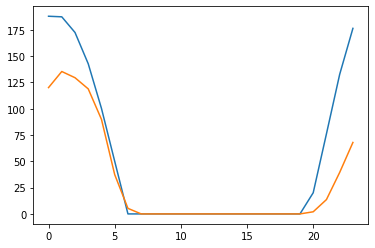

89.56293795496542


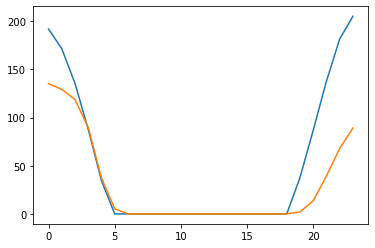

94.21711495576501


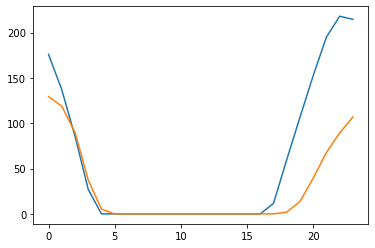

104.30028472240467


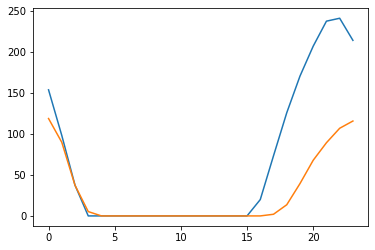

112.96709035732376


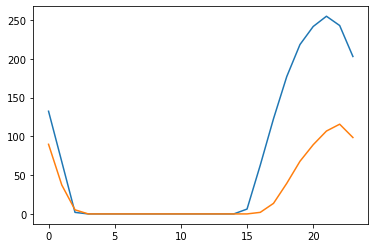

119.47151454719656


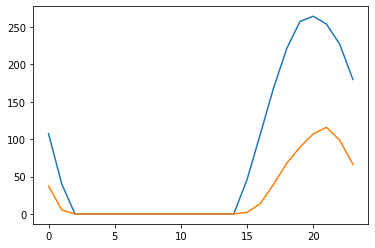

117.44985454038336


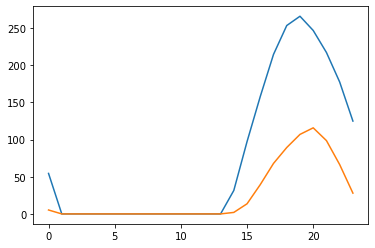

119.03843397724404


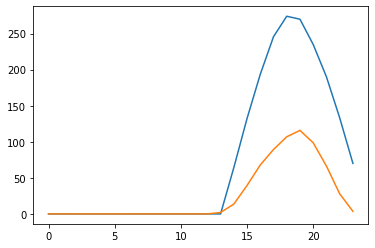

103.21572366271764


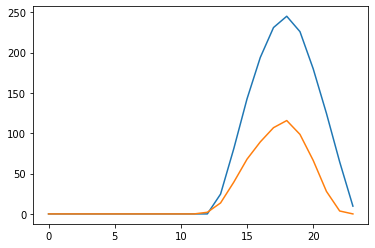

100.39235624747639


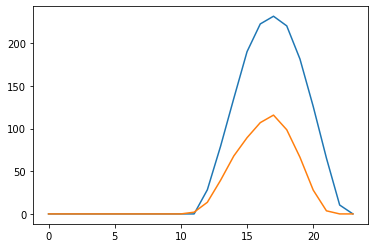

105.56332067273893


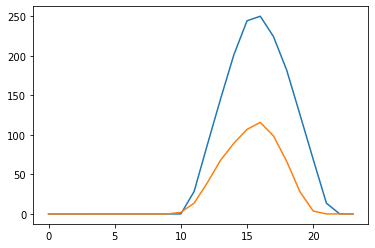

109.81034354978064


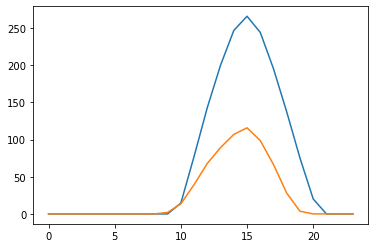

113.00604864369775


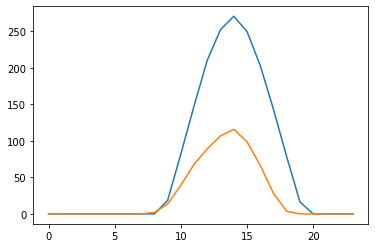

114.7128232820081


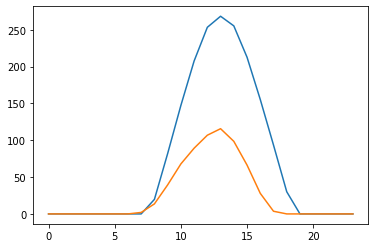

117.26197597241892


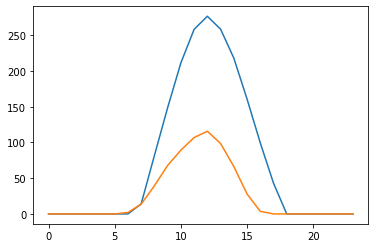

118.51017720973572


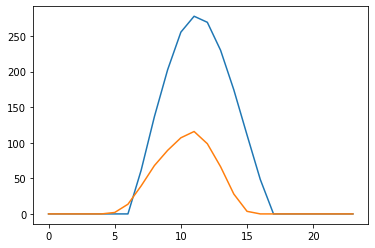

117.87641359563418


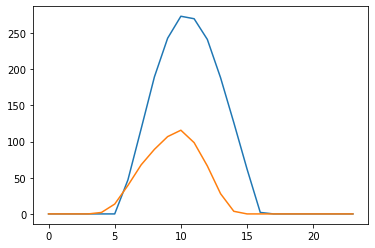

118.45724068584569


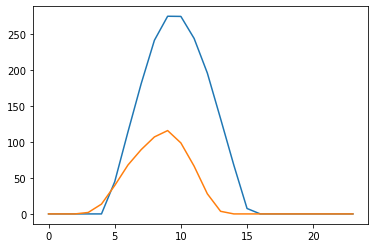

119.86938406102551


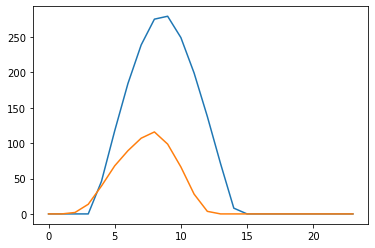

118.88440086676547


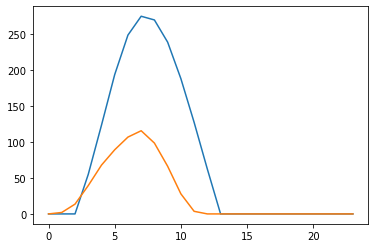

98.5541924456911


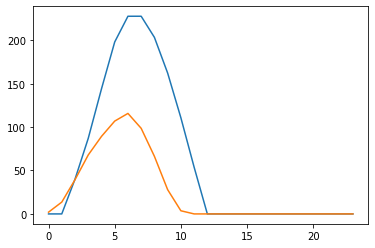

85.7004948193798


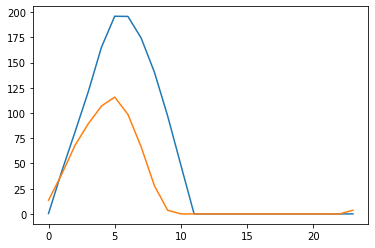

93.62554641953439


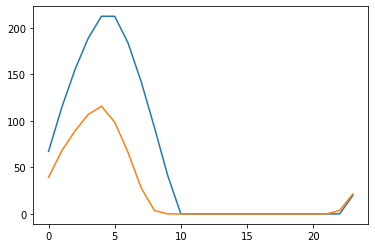

86.414326854102


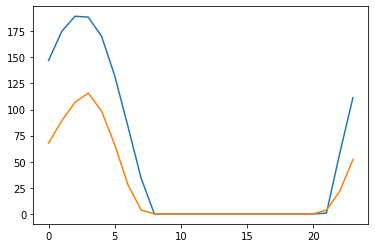

83.87044049918939


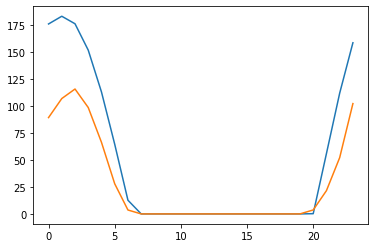

88.47219658750896


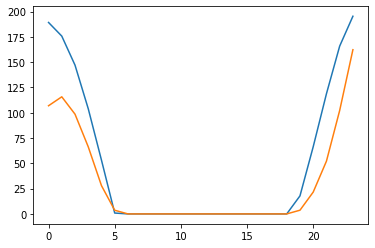

95.2109182726515


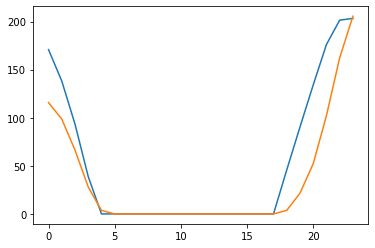

105.73951960677302


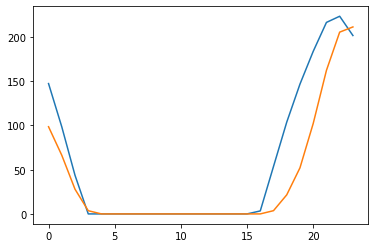

118.00903678727423


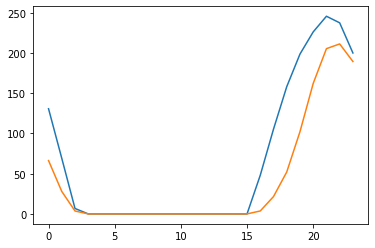

121.53678692020004


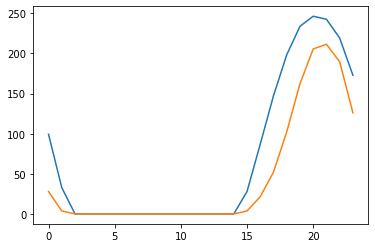

120.20022131514574


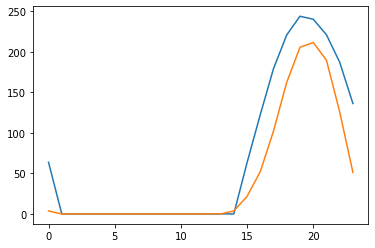

117.87388376641911


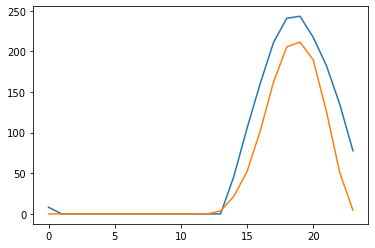

111.65819048931651


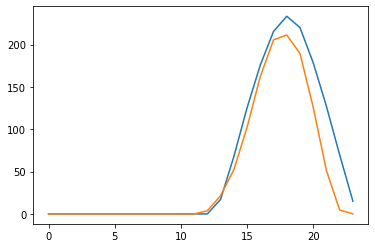

114.15216635257245


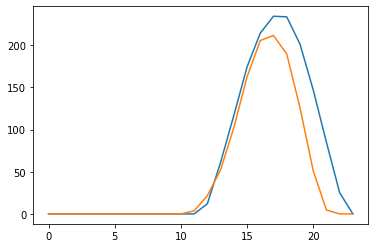

116.44720425390429


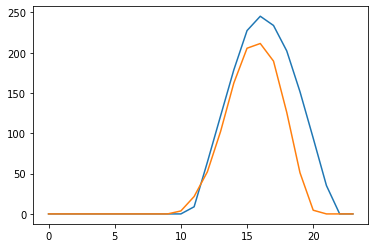

119.52352620895238


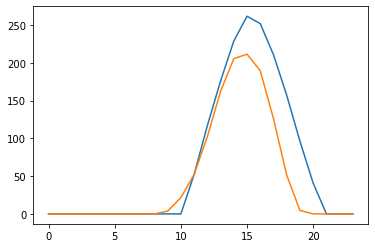

121.75471684382991


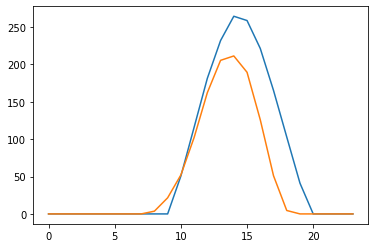

123.31389103961817


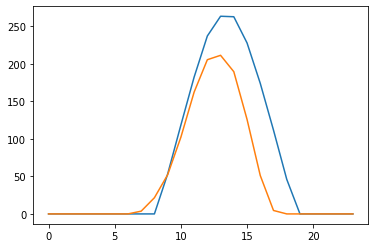

123.2657872641884


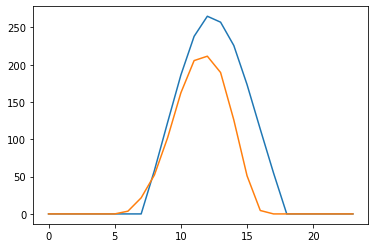

125.04801376171032


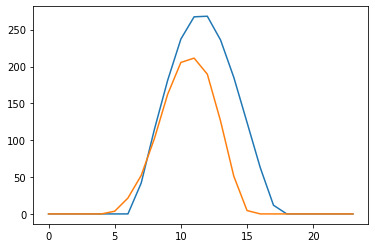

125.00039147140815


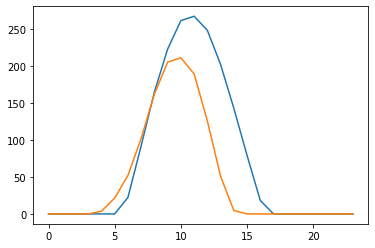

122.40209204840886


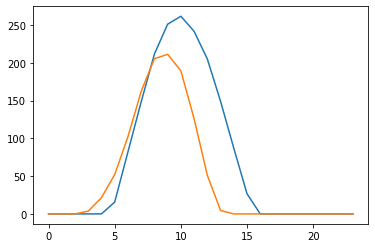

120.23846964921665


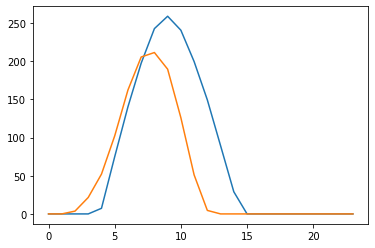

115.23967416816548


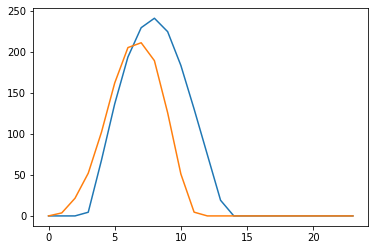

106.31876815963041


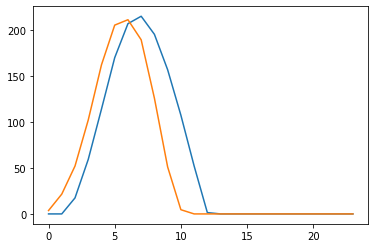

104.365232303327


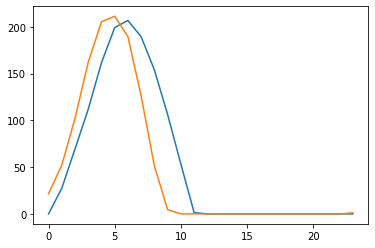

109.53227111462206


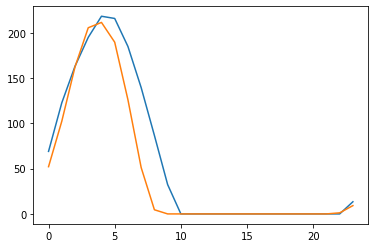

107.90069479320039


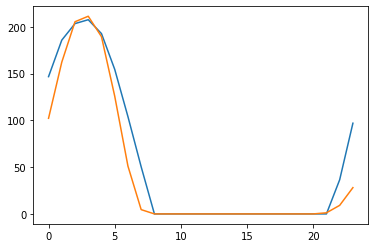

104.43411395523542


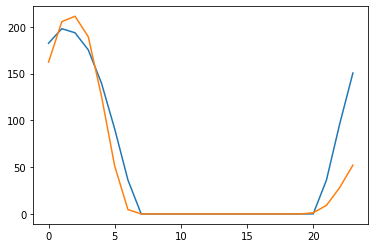

103.02071209115928


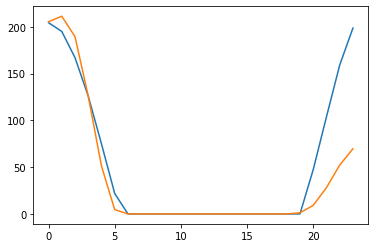

105.00533623283916


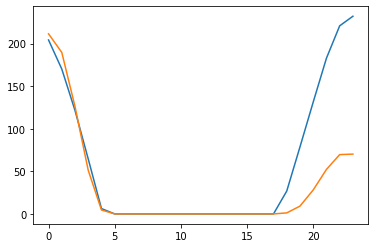

113.6561615686868


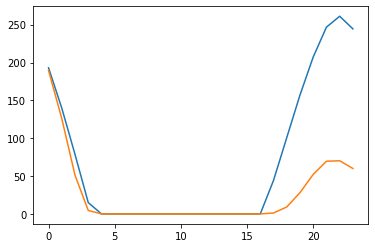

121.78279199124039


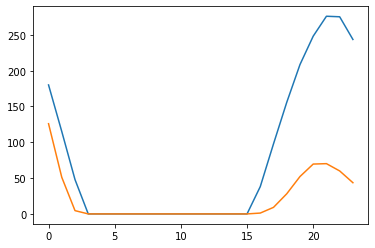

127.93134316064472


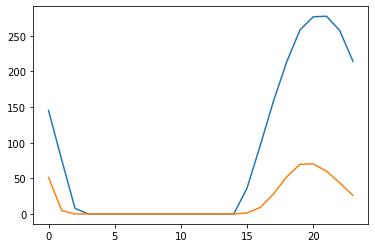

128.69221760994225


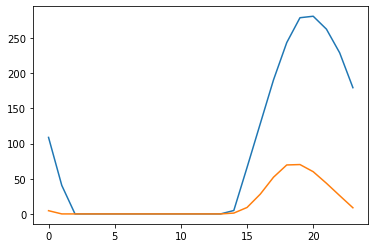

123.44541913578026


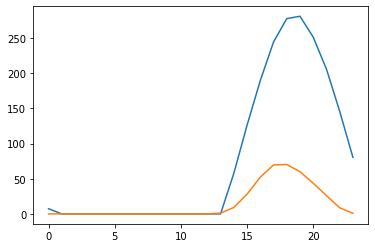

113.06783988662922


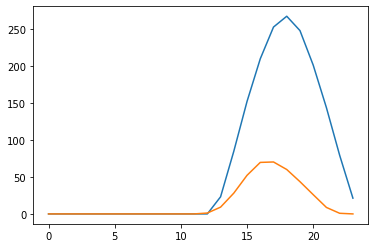

112.19041080038247


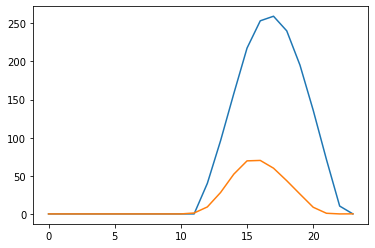

118.37079247432166


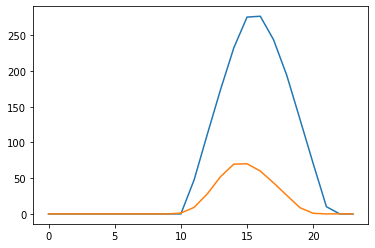

117.60151535612964


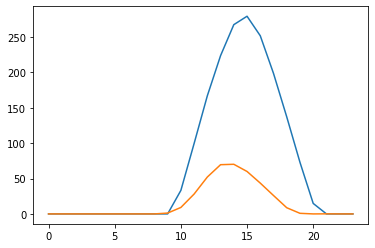

118.79980741691722


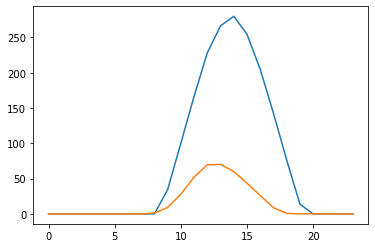

122.71152286890509


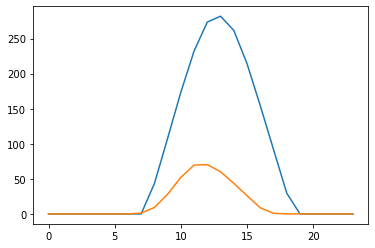

128.26010994242444


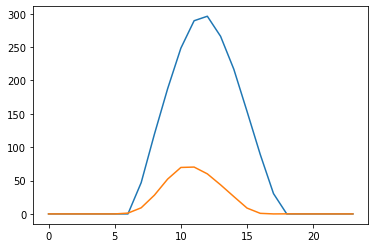

128.8081832386813


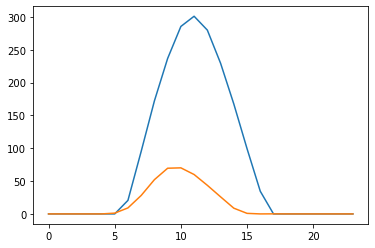

126.6518792108904


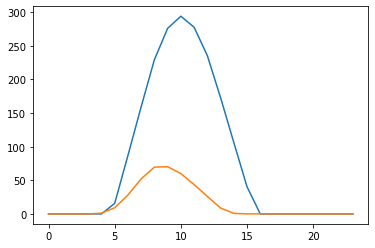

128.56478654288753


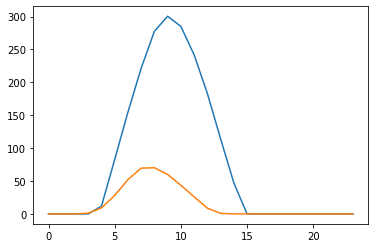

127.40283576095828


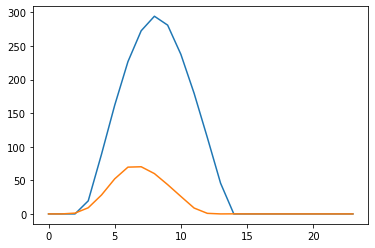

122.20561895790577


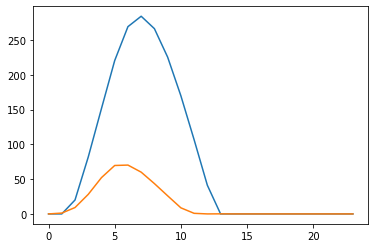

93.26047571575275


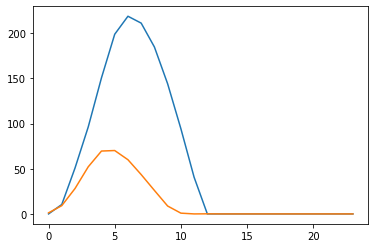

72.70881687246509


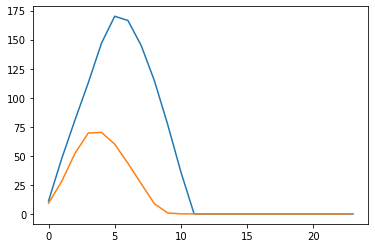

85.46878322463593


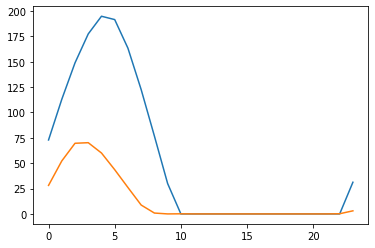

82.32356457543226


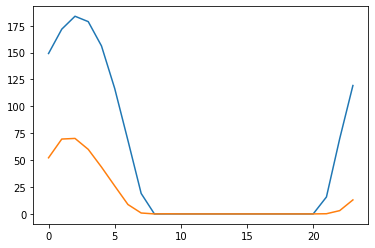

77.65711219517628


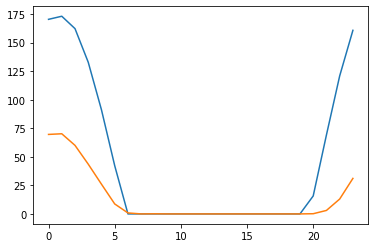

74.5677627219264


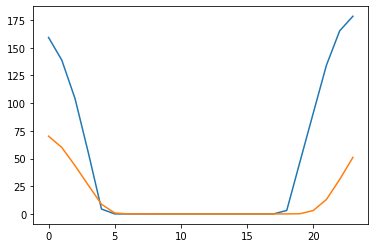

78.49516564286111


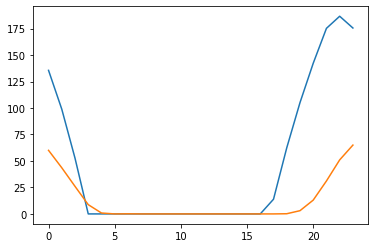

88.35046960803346


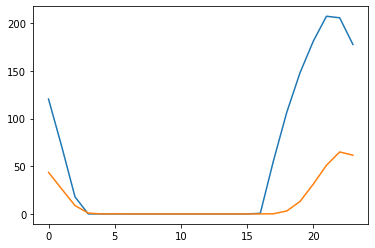

97.76910794555963


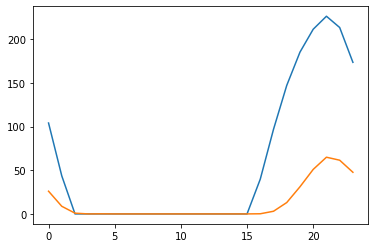

97.31788901373463


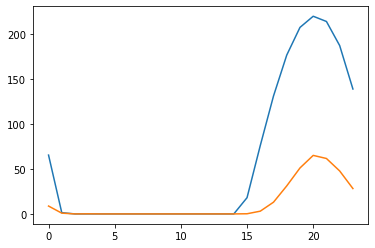

92.32420566665374


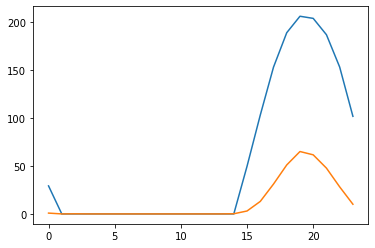

58.924948000046875


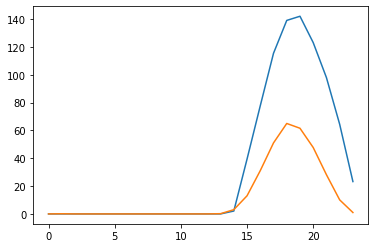

54.73628829248885


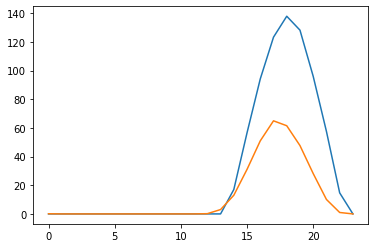

52.542003764863786


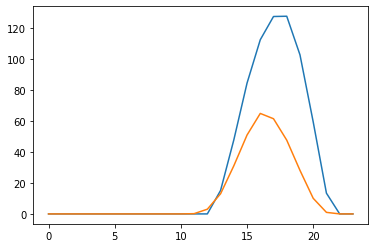

48.55102427860798


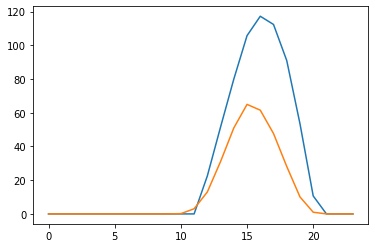

42.72224417381464


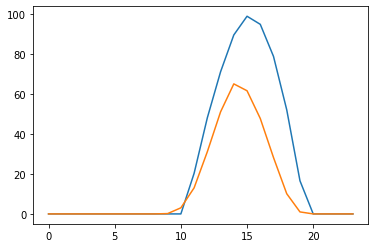

44.27903329156006


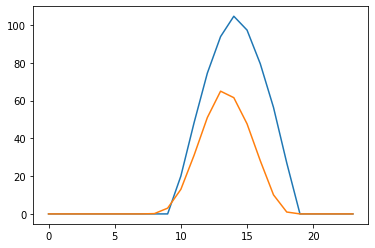

46.56473903216092


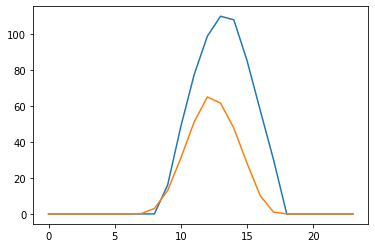

49.56055960382782


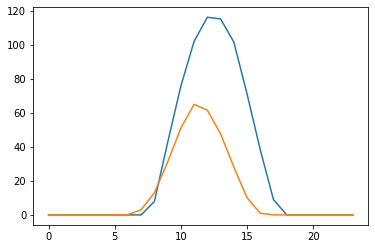

53.60232965976689


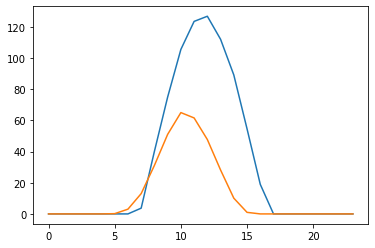

54.42457264918055


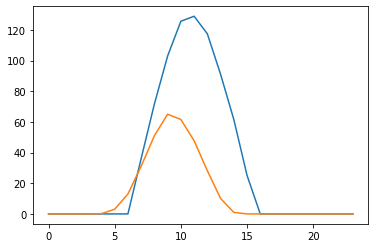

50.040850254023304


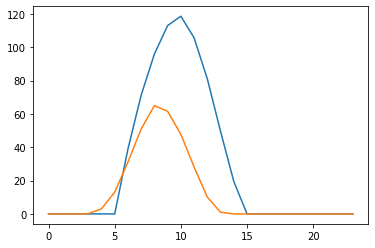

46.226562723316384


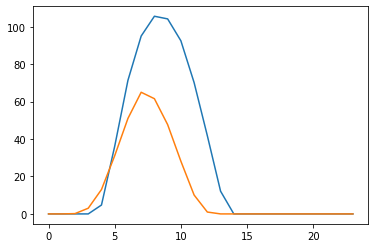

43.623451230302884


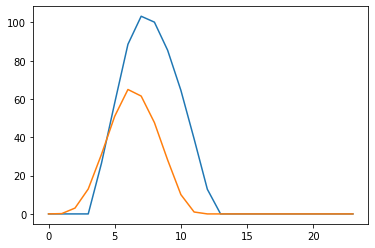

39.62917187982095


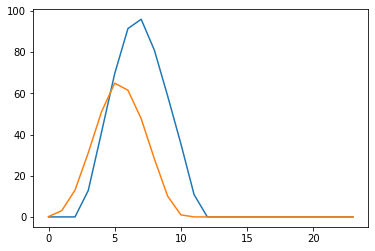

31.53849097674613


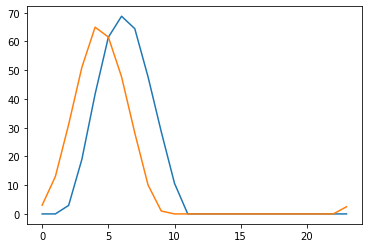

29.61834258125753


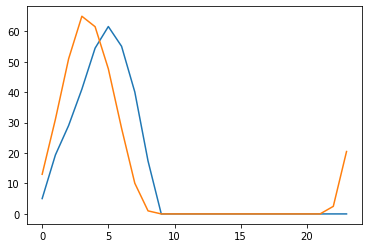

33.60504673543365


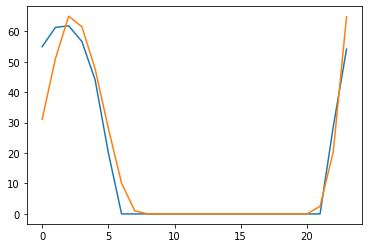

39.96249707342567


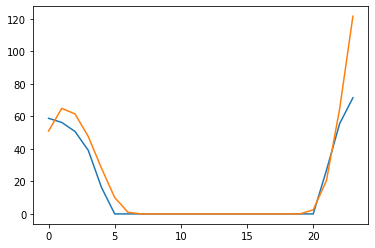

53.1235641062029


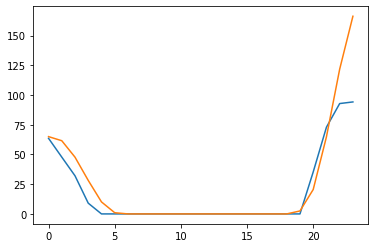

69.50467929702889


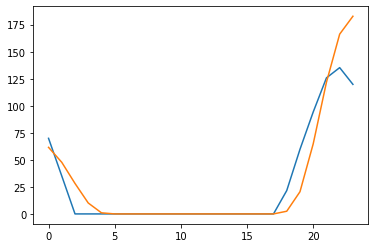

86.40978241634399


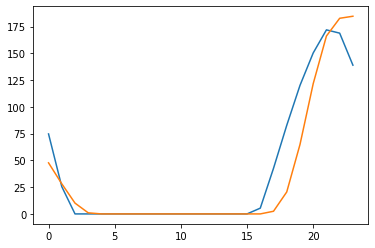

96.58117684955234


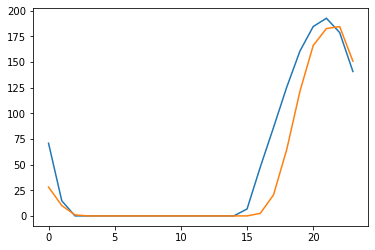

99.97657897023669


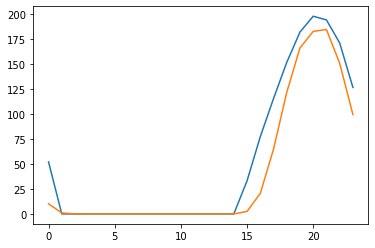

96.01715730801023


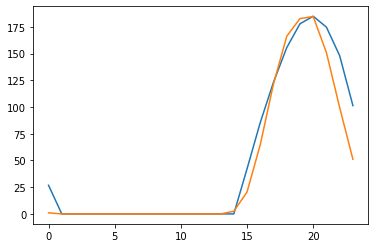

78.73216929711685


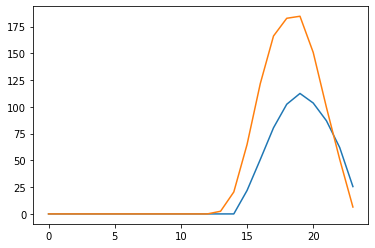

77.84786737787063


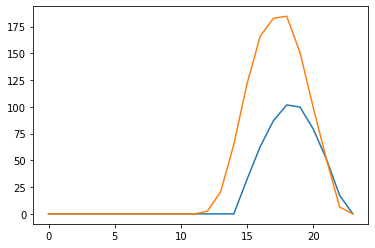

76.52014470352017


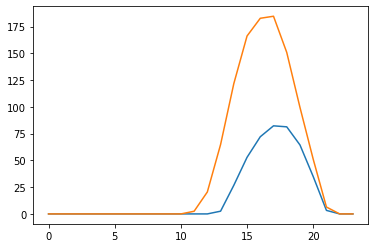

76.26916599118985


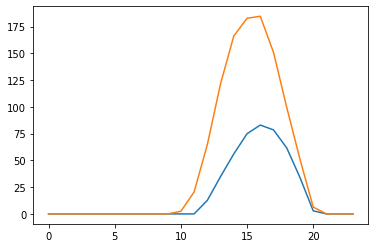

76.08769118764737


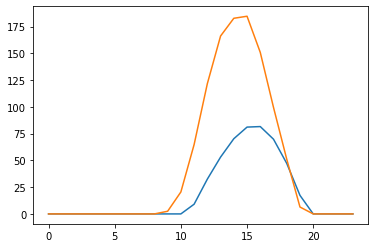

76.48328269743723


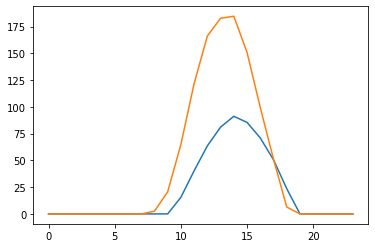

77.40369804127613


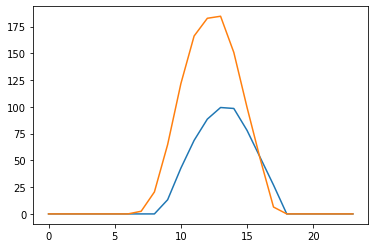

78.23468356355767


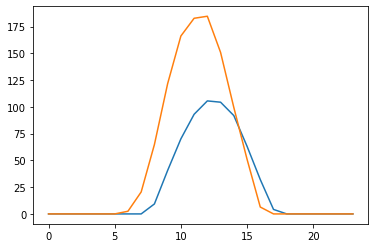

78.9712189738401


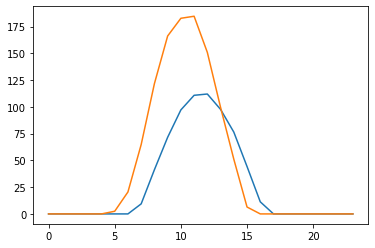

78.81684561432176


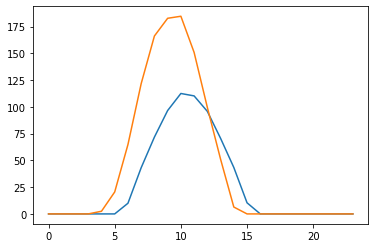

77.17720510884277


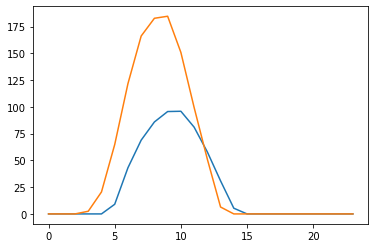

76.35660468131522


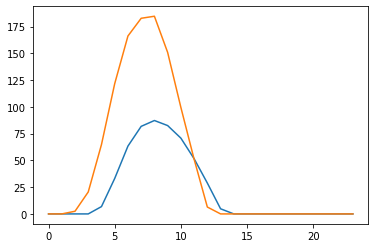

76.48827183208785


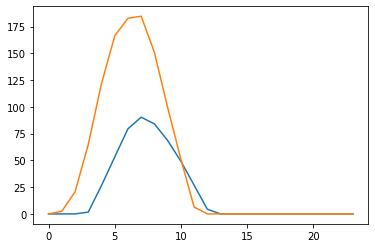

75.53303734856615


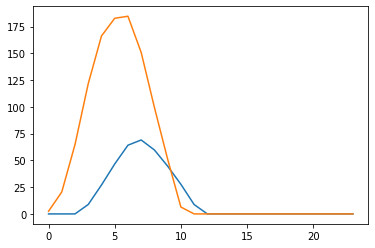

75.49201623482102


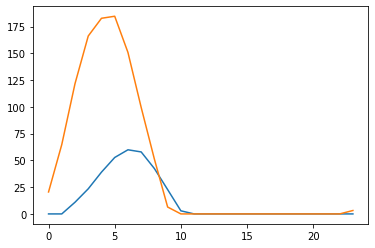

75.17492543826882


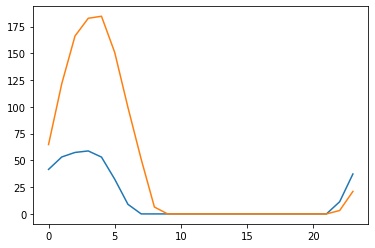

77.05305091364384


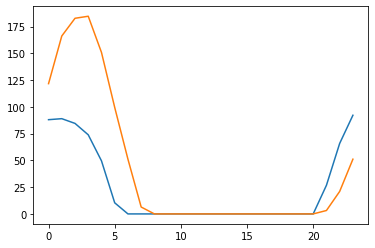

77.21747643241154


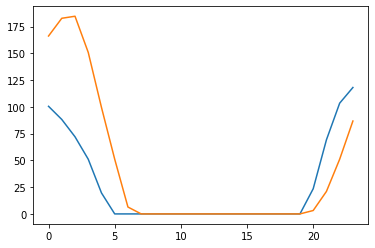

81.63355868951909


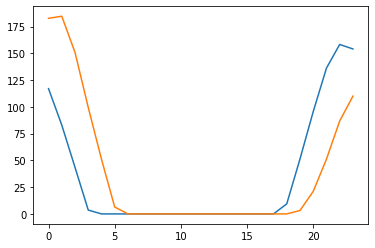

91.04606353895828


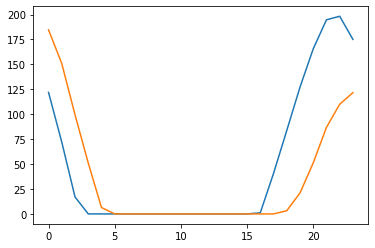

106.599865262919


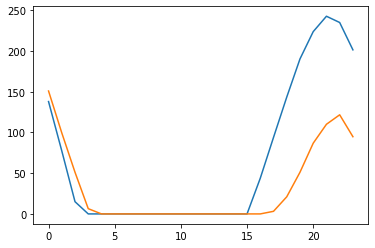

125.81647264476484


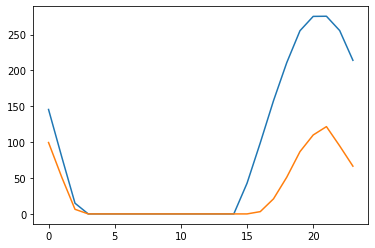

135.18565801853515


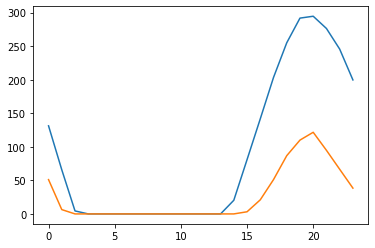

138.6437972363465


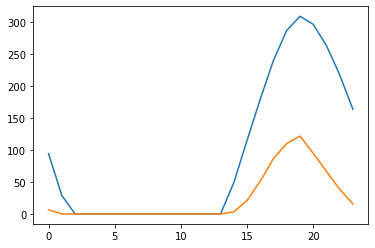

136.87916650187407


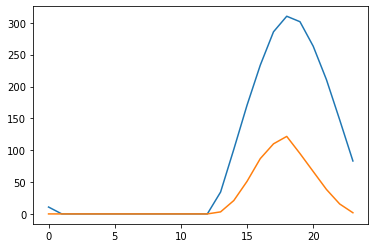

124.22938555354071


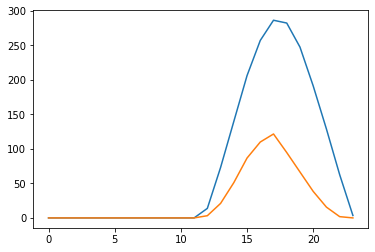

117.1234225786888


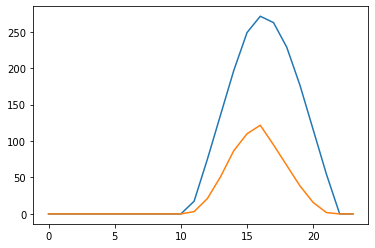

120.44463770607507


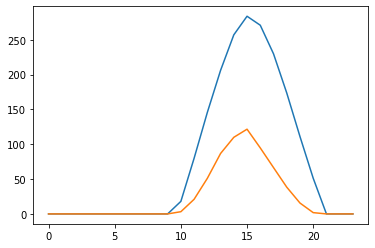

124.23584252727844


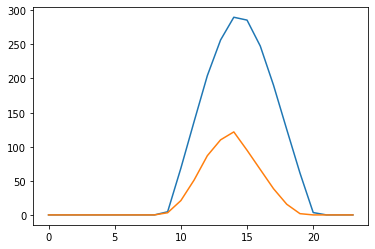

124.23918714062727


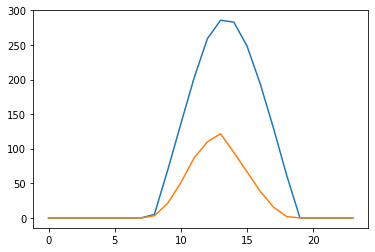

121.81288076073189


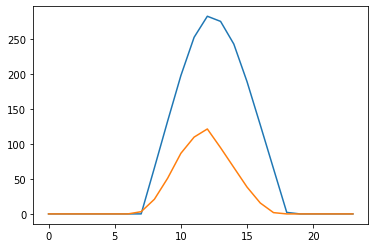

122.07719004438164


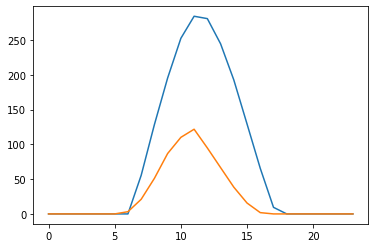

122.52840567244903


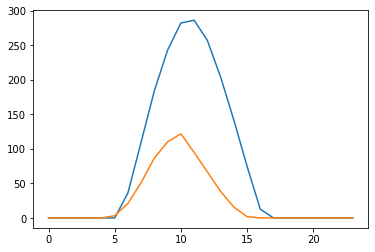

124.60695836860263


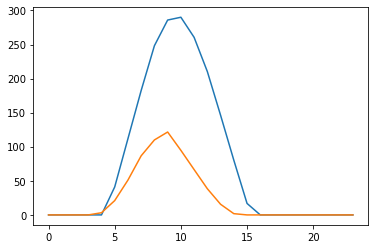

127.42178207092469


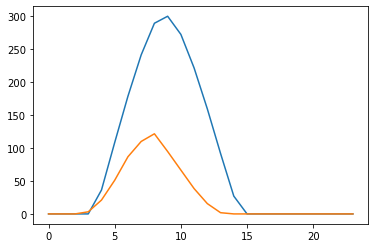

125.10907766334275


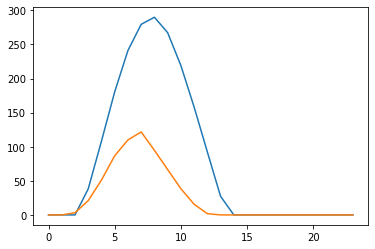

115.54215379890734


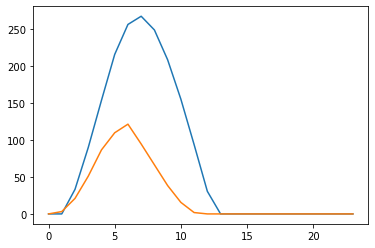

89.91536033040539


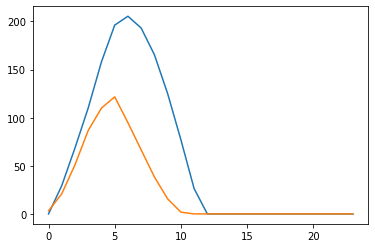

83.54789093142148


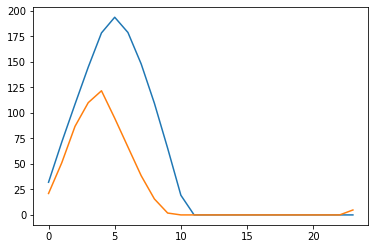

90.56092295897339


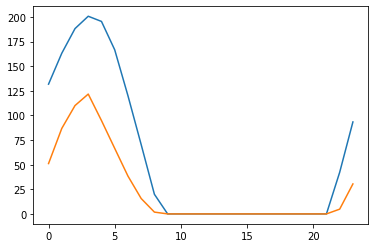

85.87874014039099


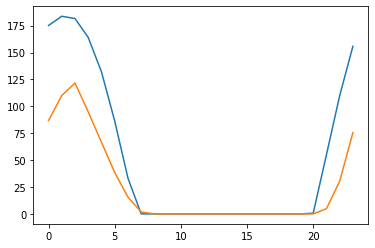

89.78495966826004


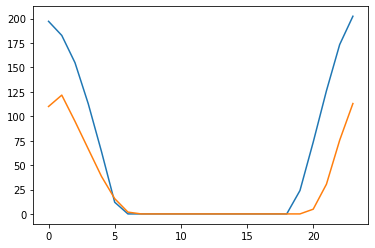

93.95364790349582


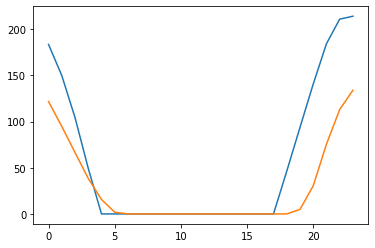

100.93264966497757


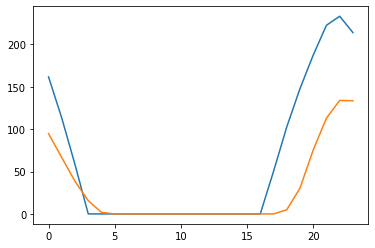

110.57591306626297


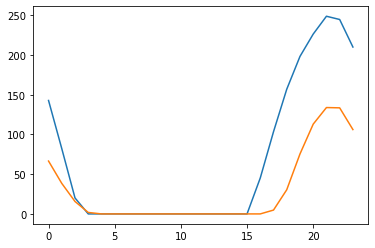

114.95877017077882


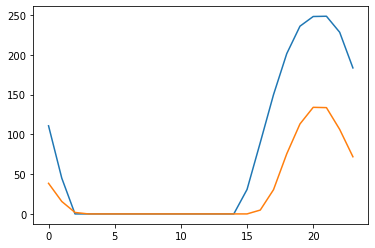

115.30501719034014


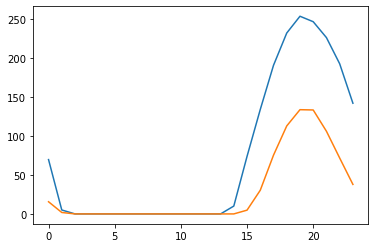

113.65330165624522


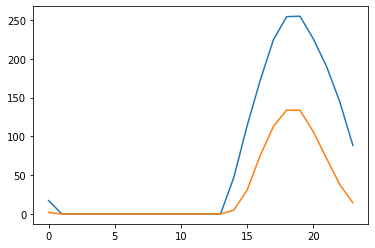

110.51477341485675


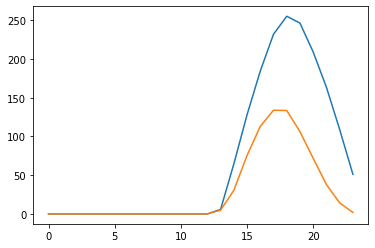

105.75708758838336


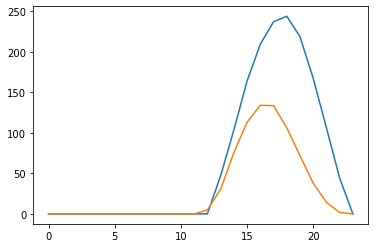

107.84541709089511


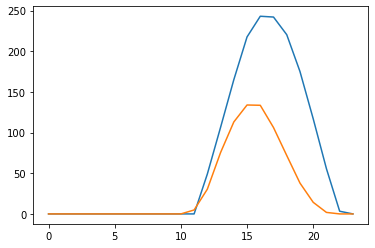

110.26041984318867


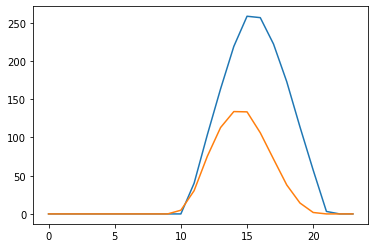

112.01373501684955


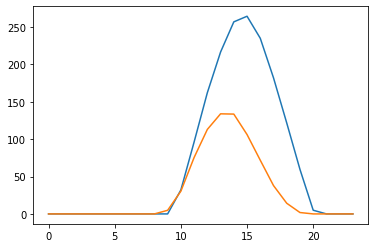

114.61588345172075


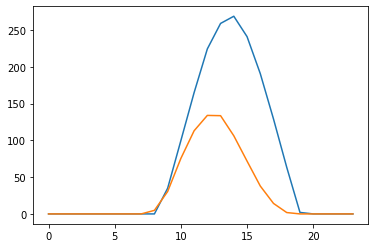

115.82708630920017


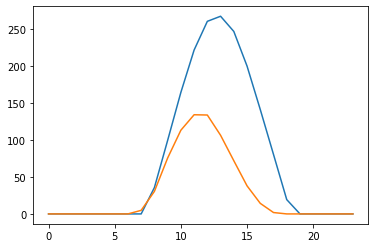

118.1620745549721


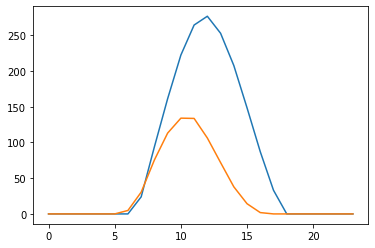

119.71036087466389


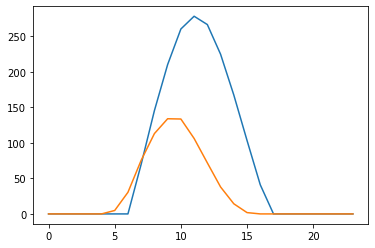

117.1746096096091


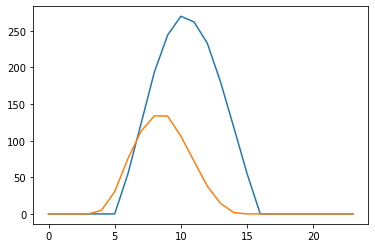

114.74086284190211


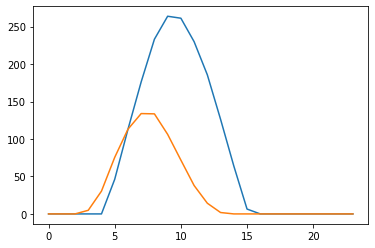

111.6662696326405


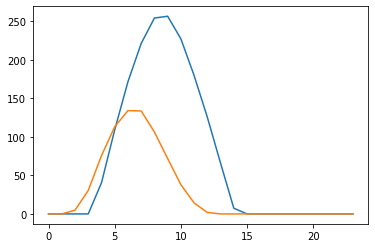

105.76193912868695


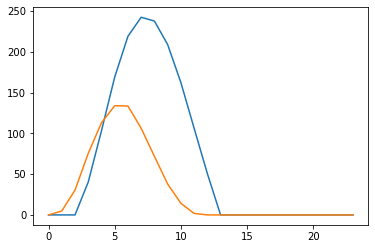

87.60380346353968


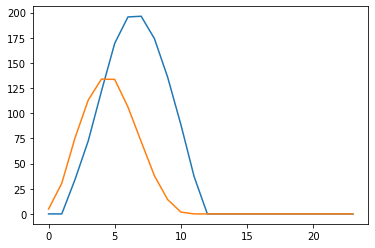

89.8837970962108


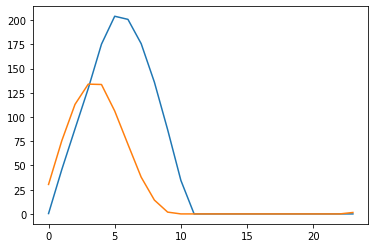

98.07549421145899


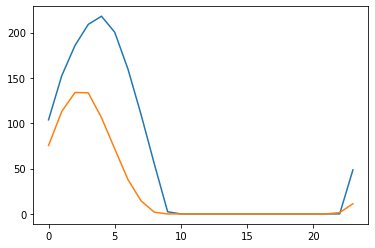

93.77789303640152


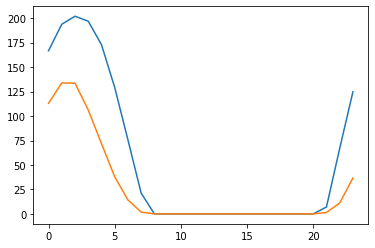

90.1630312941829


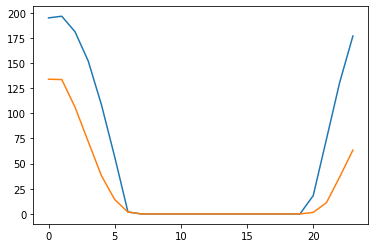

90.47406030218201


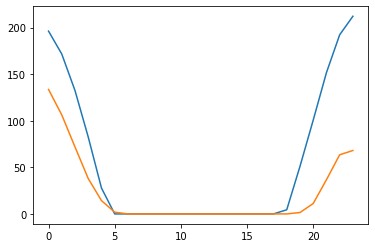

98.816836289879


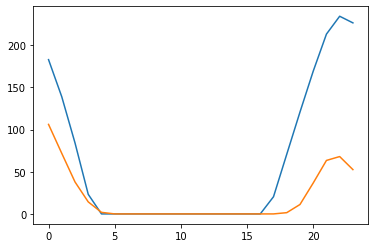

109.44029979616532


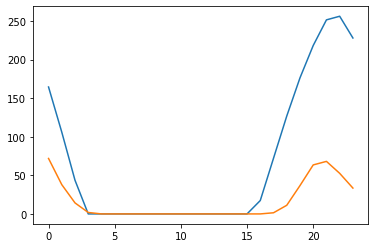

115.16713859380395


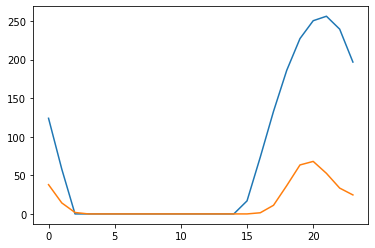

112.27842081028376


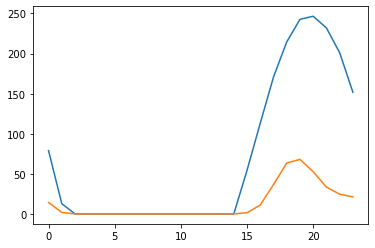

110.97960599701385


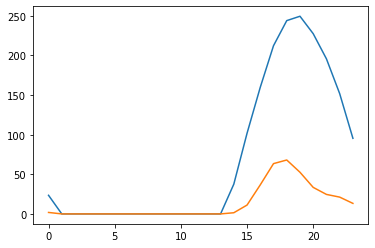

104.07109564644914


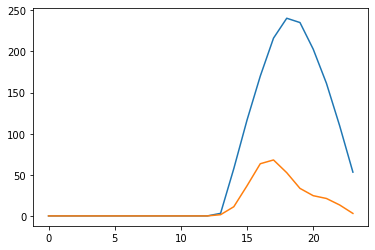

100.56325626109006


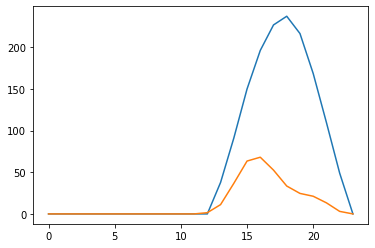

106.16220413615405


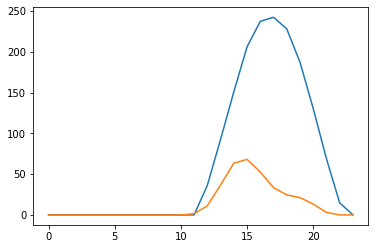

110.16553937621731


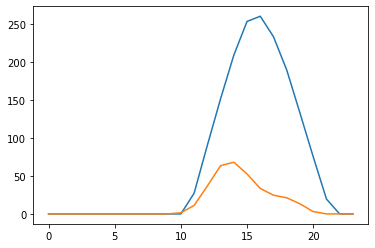

112.70191932567647


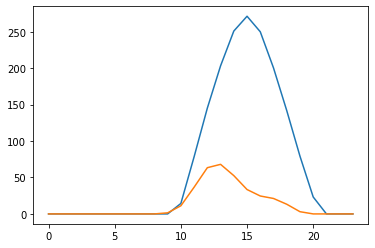

116.15012107374233


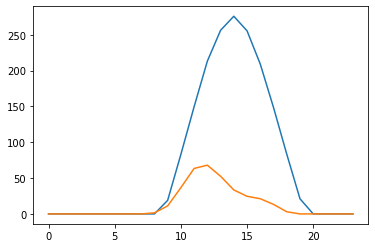

119.52667237820643


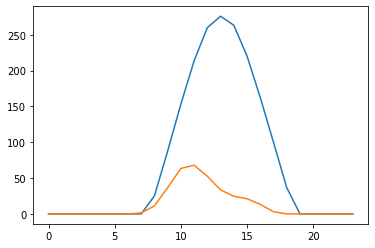

122.90412460847931


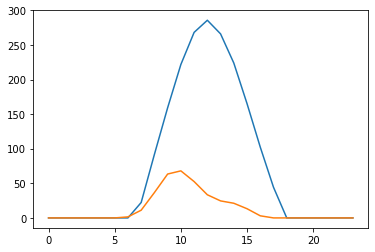

121.959138542652


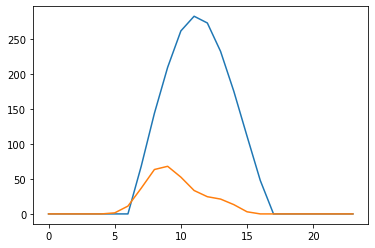

119.33428305282162


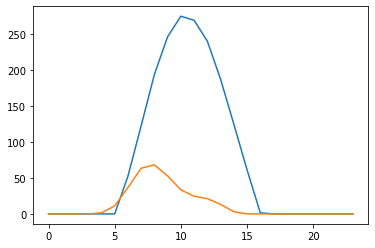

118.08262965926389


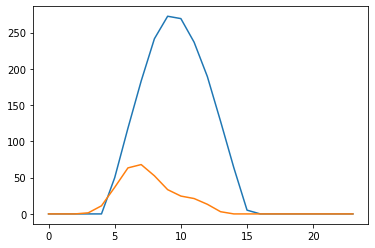

116.89759471341968


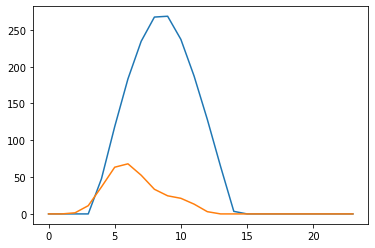

112.82544154364719


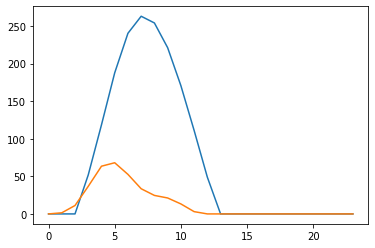

89.86407160419786


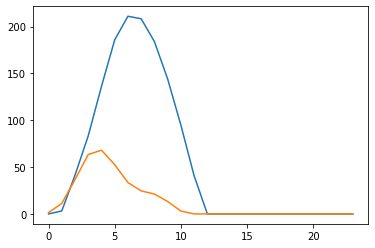

75.5732139207534


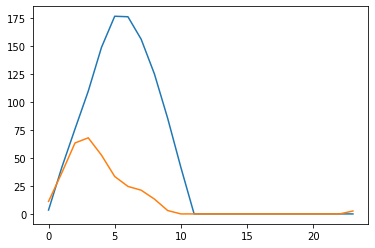

87.58475013801174


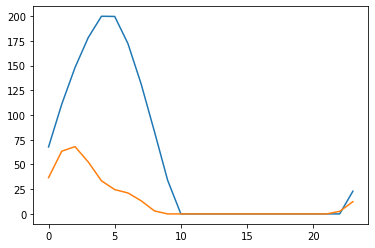

82.80963850110247


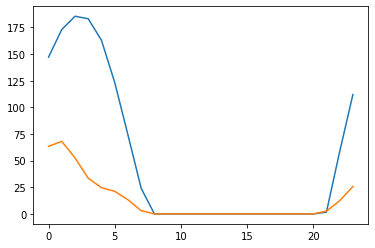

79.00789489717648


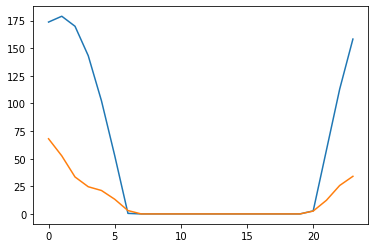

72.62361715331005


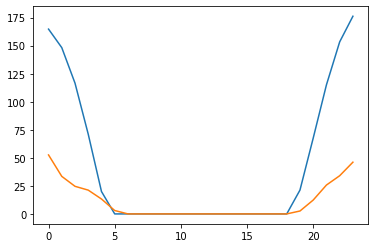

71.83527266632073


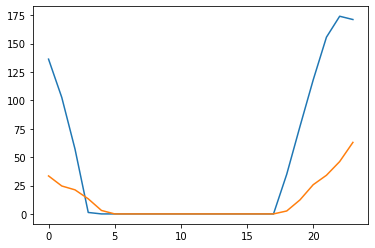

77.09853358941689


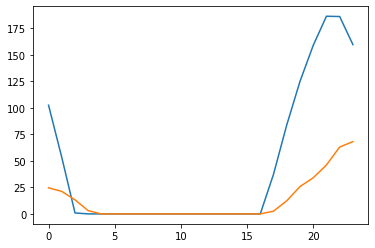

85.54357659304632


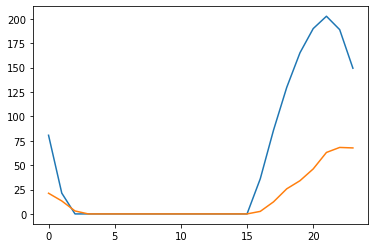

91.14534095053784


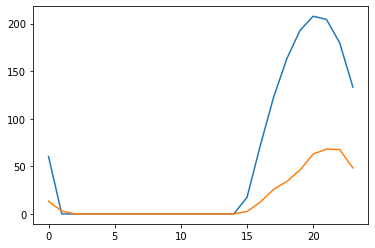

91.00341579342239


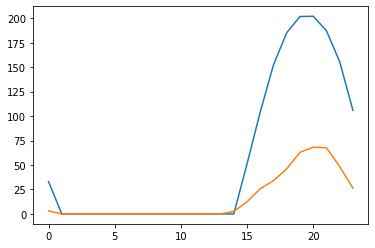

70.48800957748779


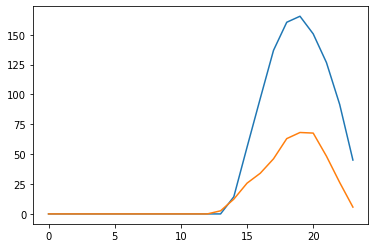

58.160475682358225


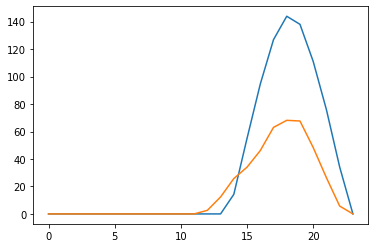

56.97241848196929


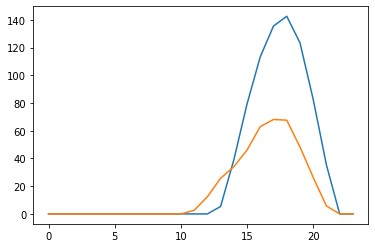

56.13658324212191


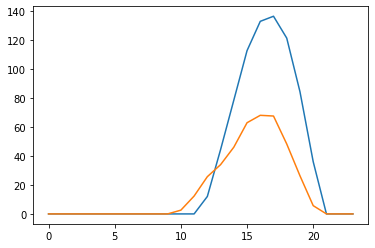

49.672440001610084


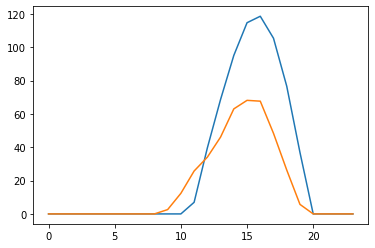

45.579747507580144


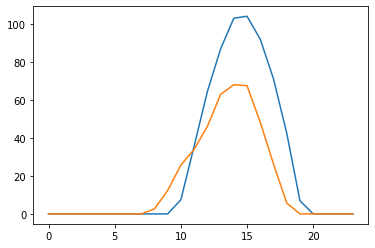

49.52473408957763


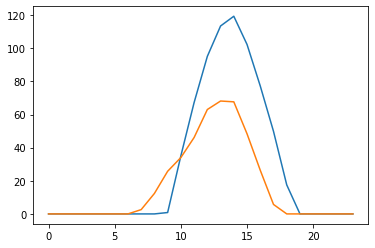

49.863490096629484


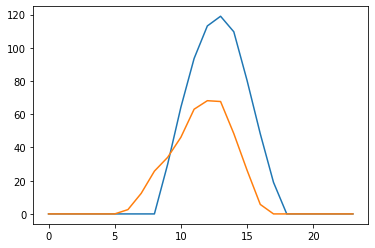

51.535929152339556


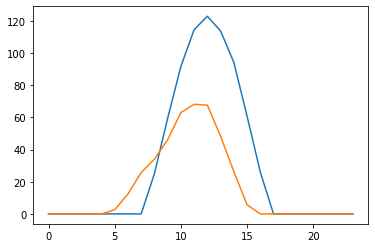

54.48422642095188


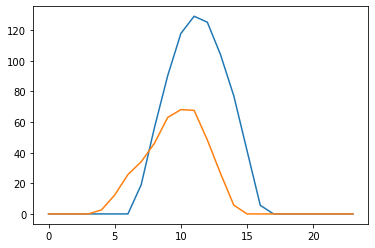

52.05934126704964


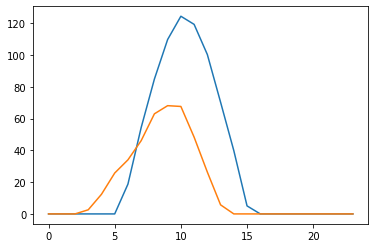

47.906758107824096


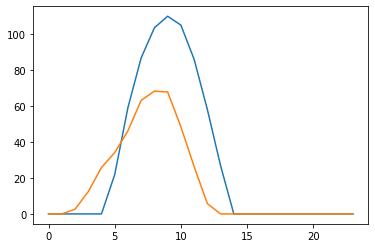

45.551793440909925


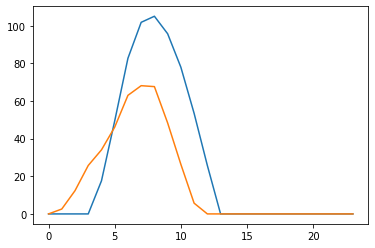

42.945063519442


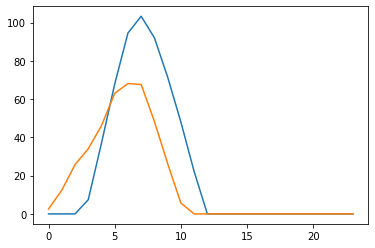

41.85281904573727


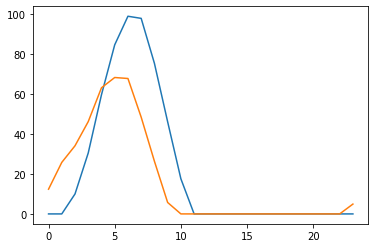

39.60724012727466


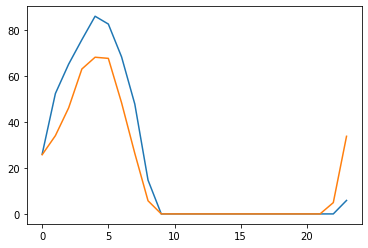

42.006754577110634


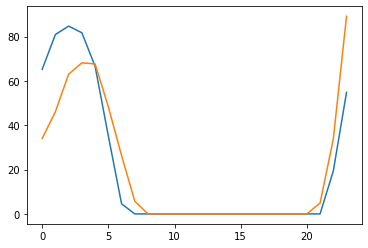

46.300681976971426


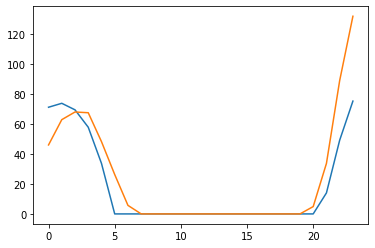

55.238461909318524


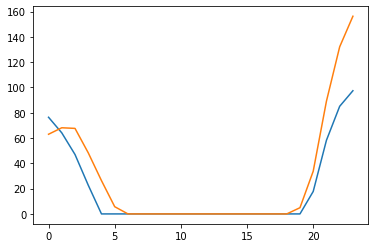

69.55808474865663


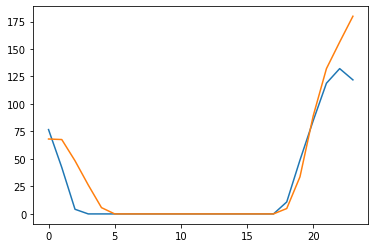

84.77585169878807


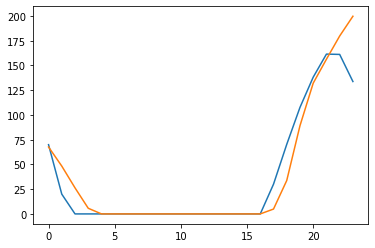

98.96430912176297


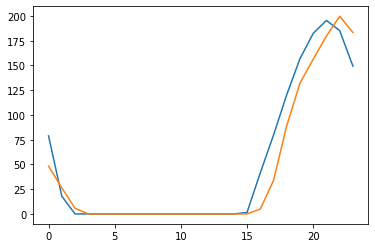

106.16888488053647


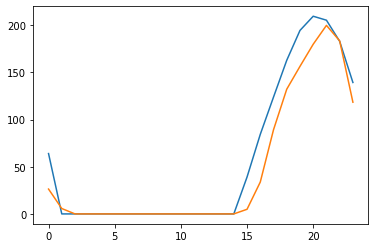

108.35925585139633


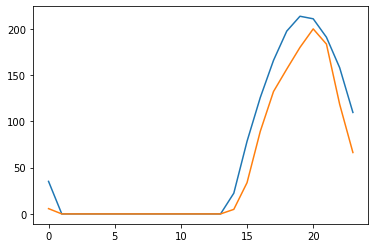

106.93403891577528


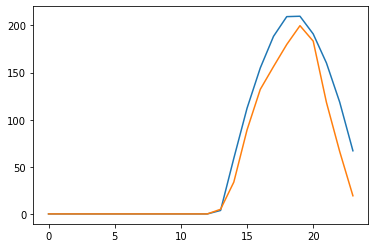

92.7588965138771


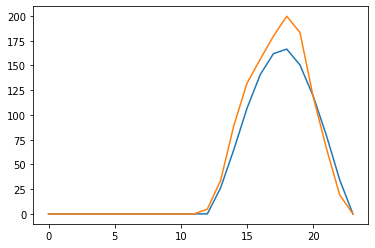

94.41319691230919


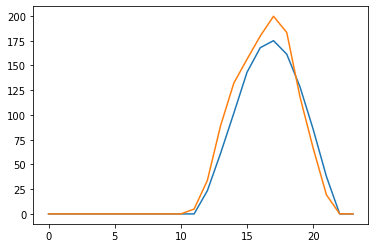

97.92608728354318


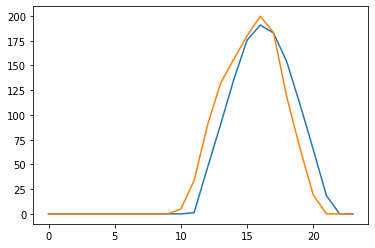

98.4891002726859


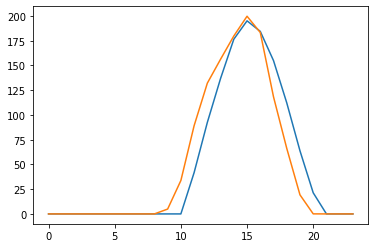

102.67353997952989


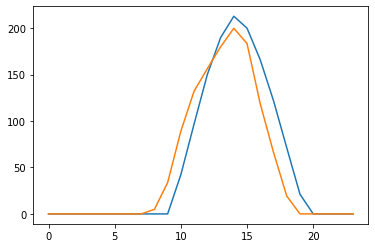

105.81131073250423


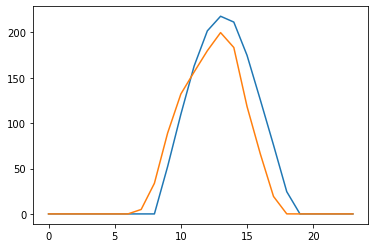

107.80721382574453


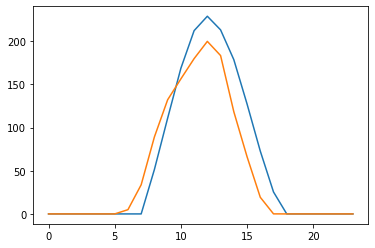

110.41445478174961


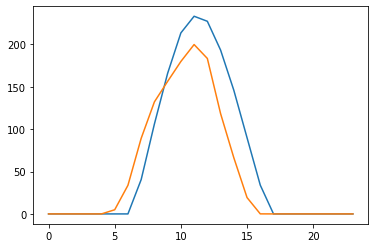

109.95793529563163


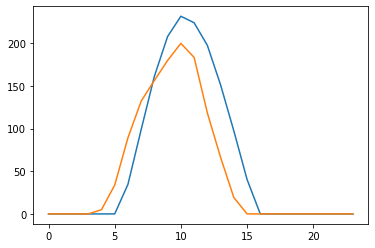

106.92769925570782


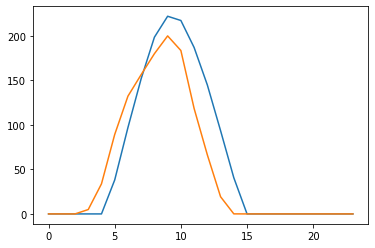

101.56613695098329


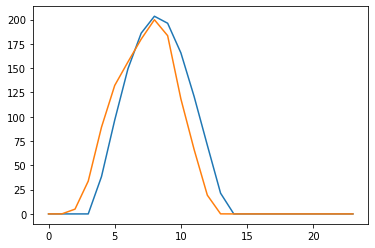

96.62389605256858


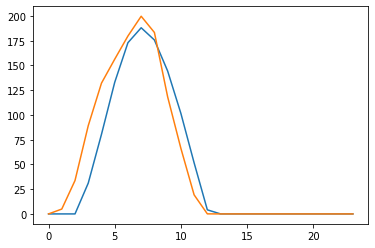

84.59076816764346


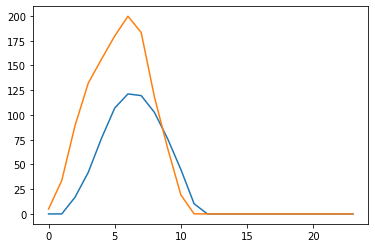

87.34982849463209


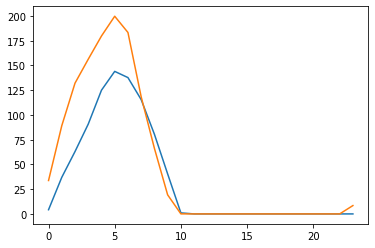

89.12134280054343


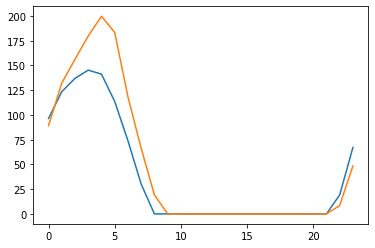

91.5110537104465


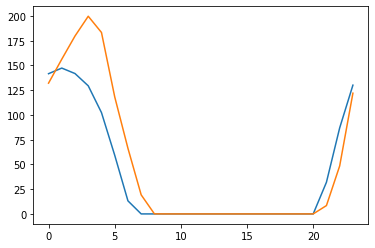

100.01764214759538


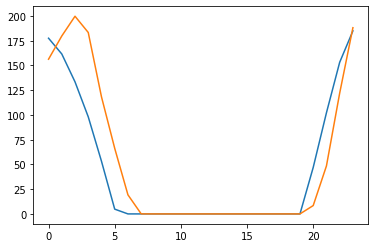

111.10607374708592


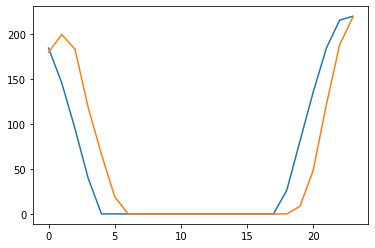

123.60809960828291


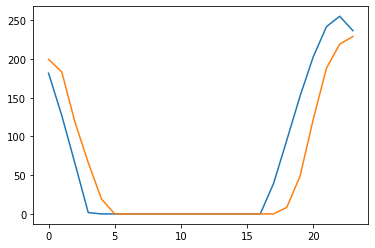

130.30939406238602


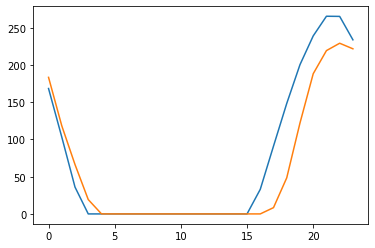

134.25220072021787


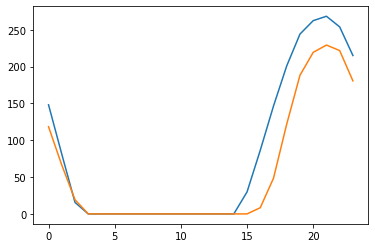

139.39329253835442


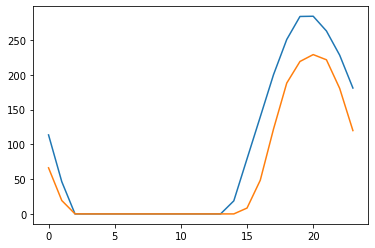

141.7824493214268


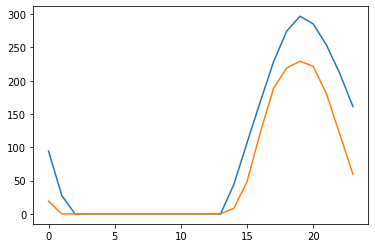

140.69171179175257


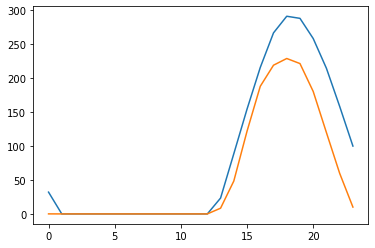

131.14546738375142


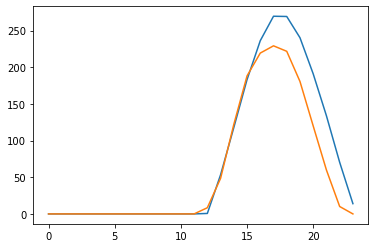

128.45675394320492


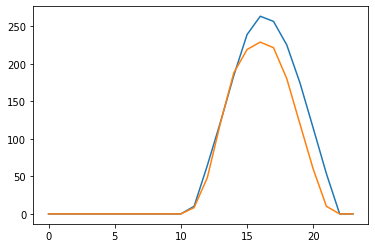

131.2380207679506


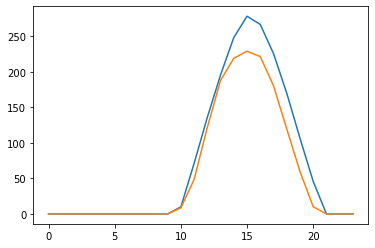

132.5948681494026


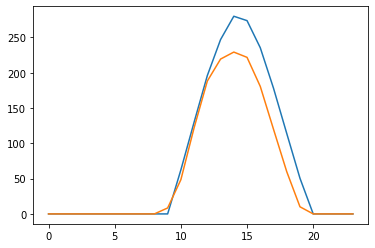

133.35463473062794


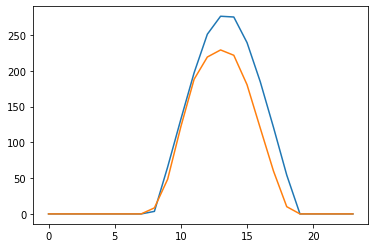

134.67032634500646


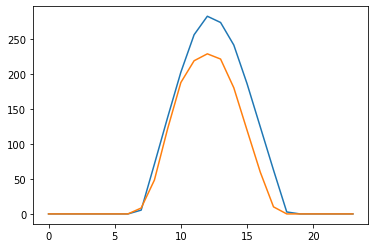

136.19260060315958


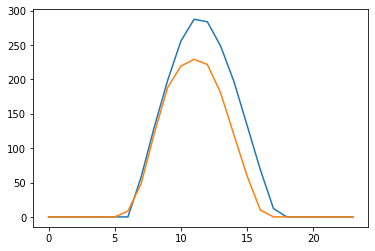

133.70093513255645


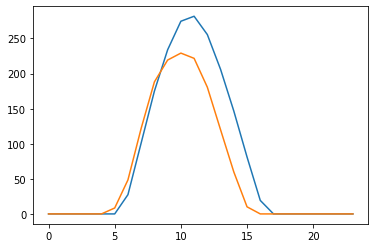

133.32308884284174


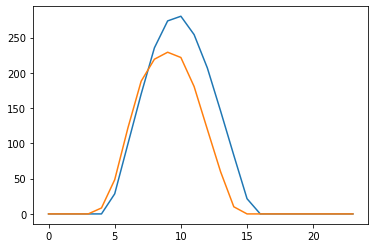

135.4699566029186


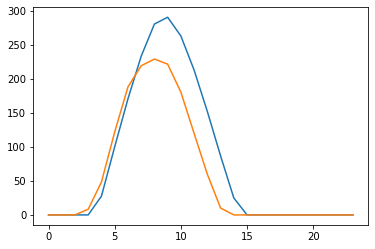

133.02264657551478


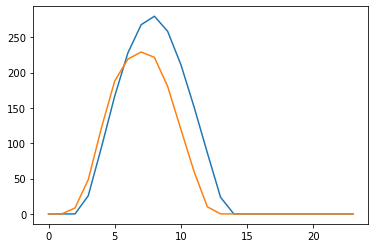

127.41340029864773


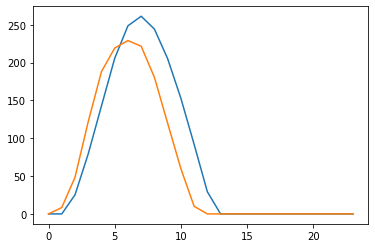

114.68842207163495


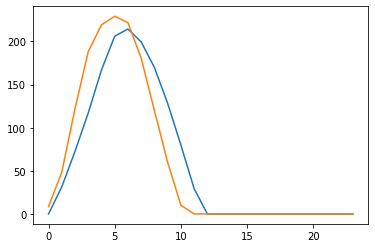

119.83780364016995


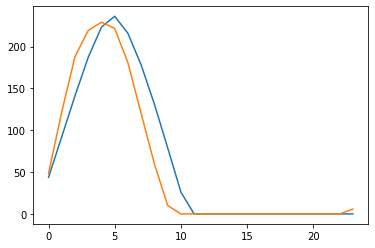

117.1828144542663


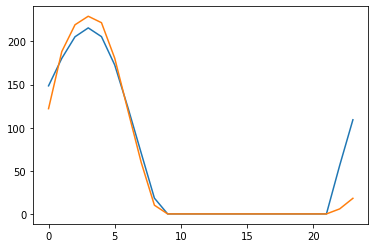

115.14004900416316


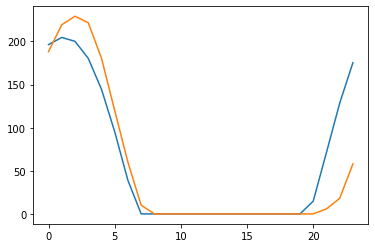

116.71111781601066


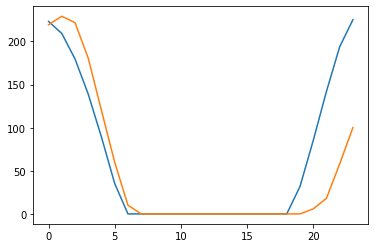

123.12433674831905


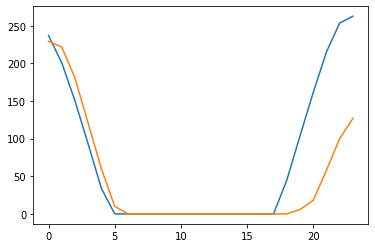

126.53889736864905


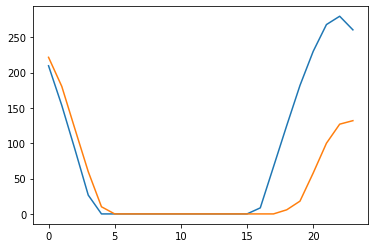

134.14901705890114


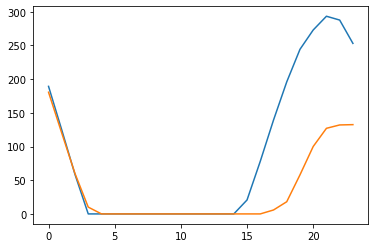

136.58939305697942


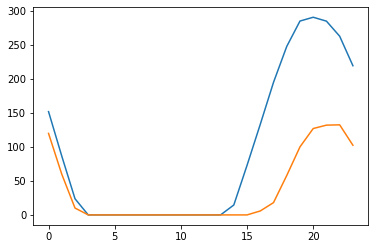

139.17692702642134


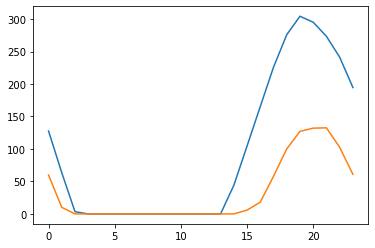

143.82979745227075


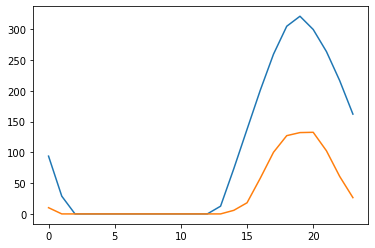

148.81750417321823


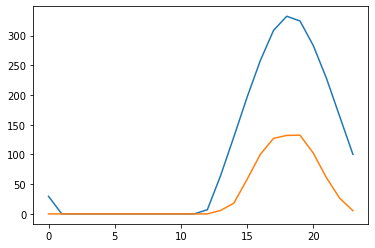

145.5983223479001


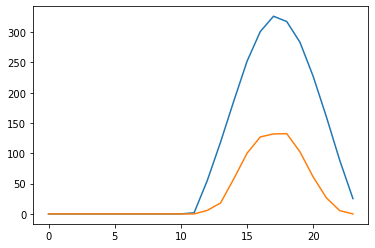

148.7474707100888


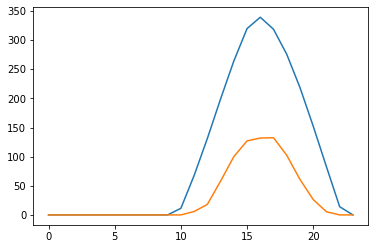

149.709739595314


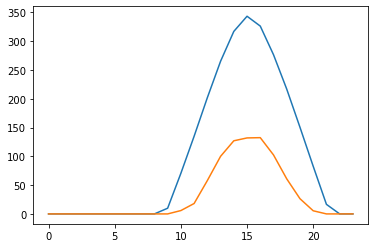

145.87626349091826


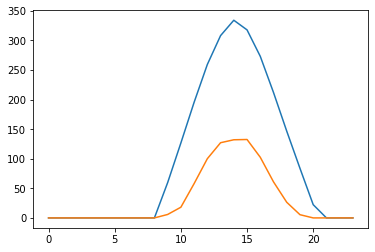

145.65012676458525


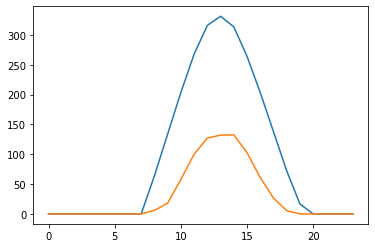

148.66023085351347


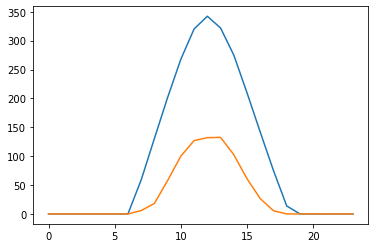

149.91975299790244


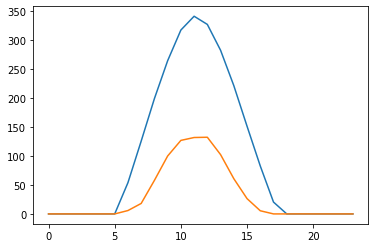

148.27705380343698


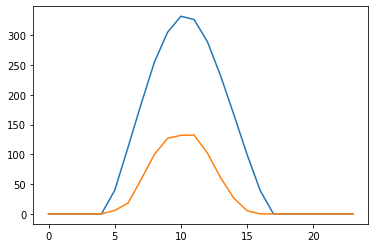

149.21948440791797


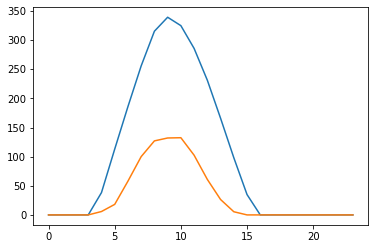

145.51456721097628


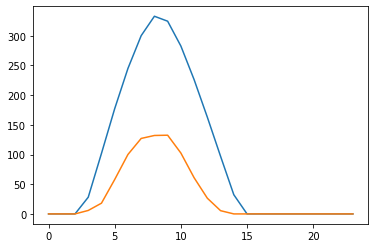

140.58468293086335


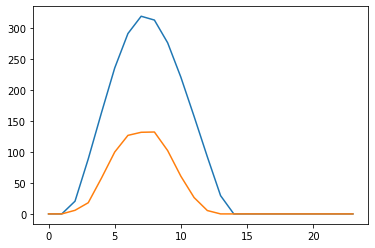

128.7838580547353


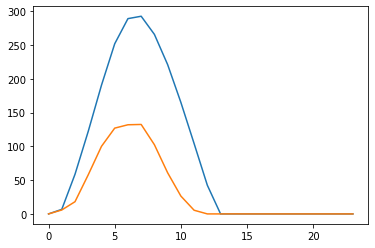

104.08304211546923


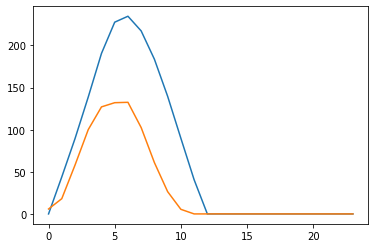

100.90457824956752


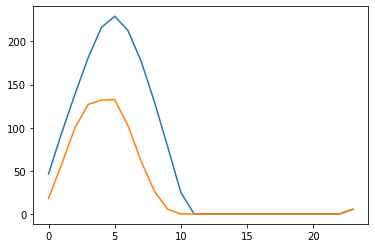

90.65279160264414


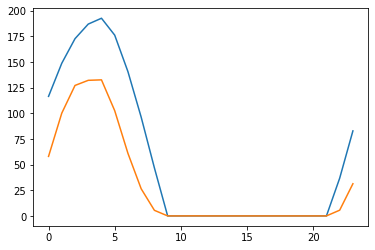

88.69801733276132


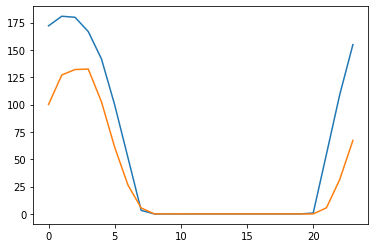

88.87195605350394


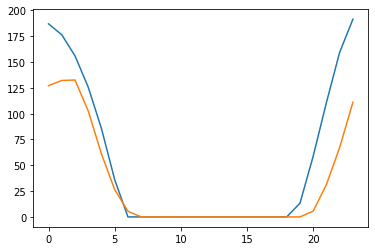

91.63003940116424


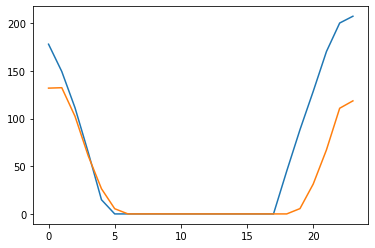

102.07203274530852


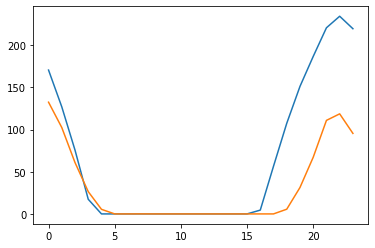

114.13186310712923


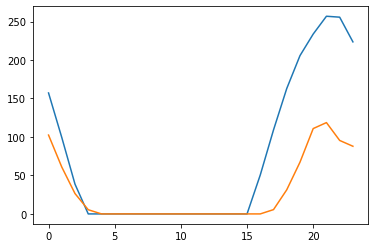

121.40597344558185


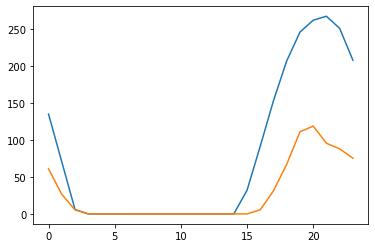

124.72178306727541


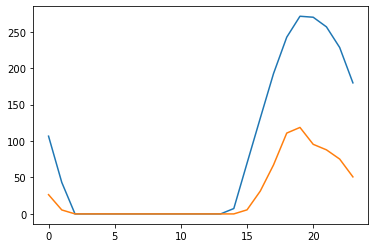

128.18523580863388


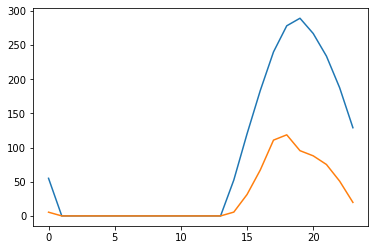

130.63283616683296


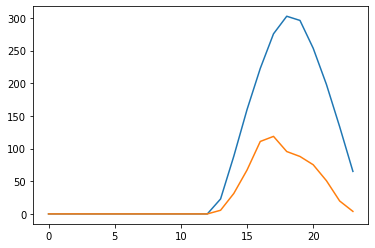

125.55368666968822


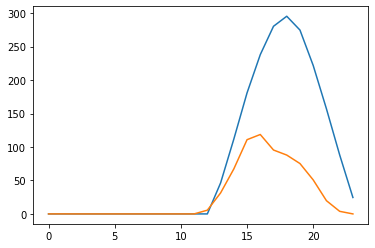

121.90588411998628


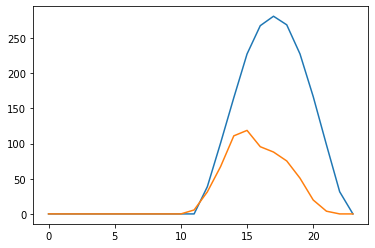

123.99351652205017


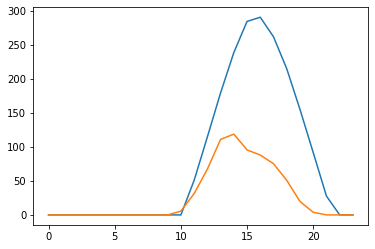

125.04438954874124


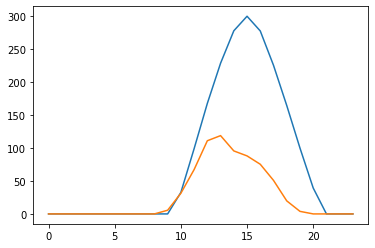

124.97470432222299


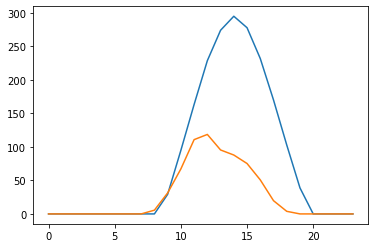

127.44306041949861


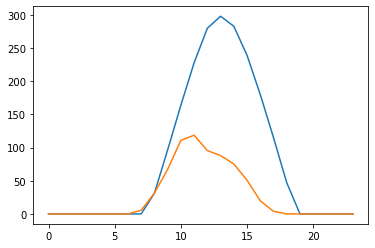

128.57665104236472


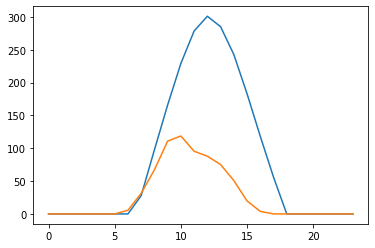

127.79678957963792


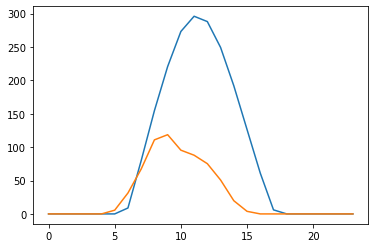

126.5833161886464


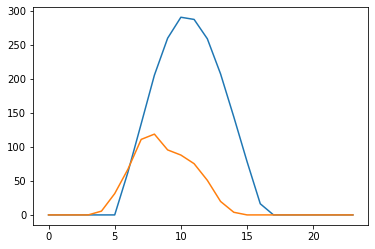

128.34269704634377


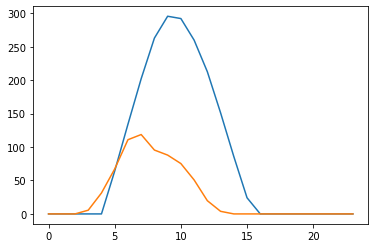

131.48148453795872


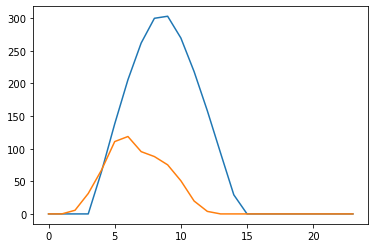

131.5299167557537


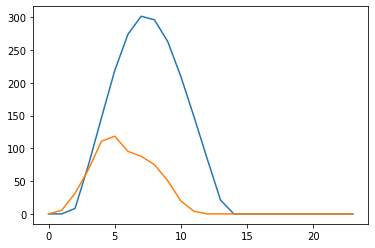

119.07612927973987


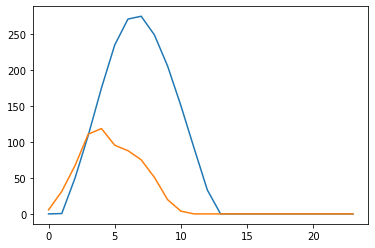

111.69468154395423


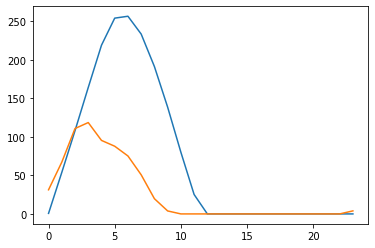

114.61238274533927


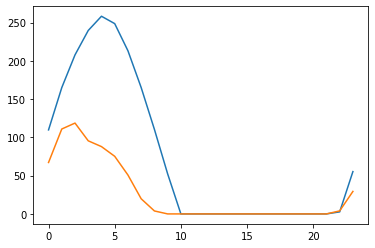

104.7466895768452


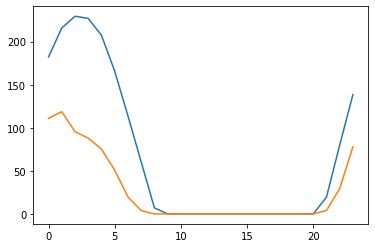

99.27115171429529


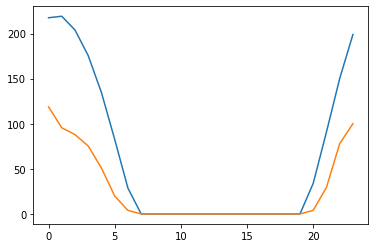

100.9150553201421


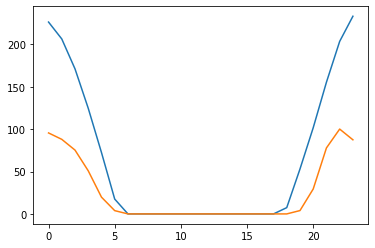

106.65003318978158


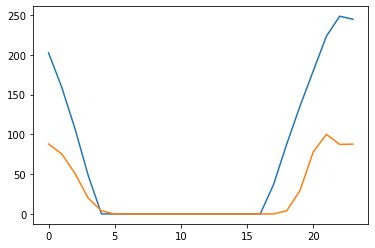

116.23110064473597


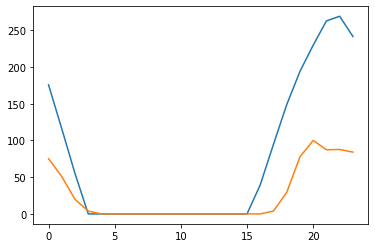

122.6123926427616


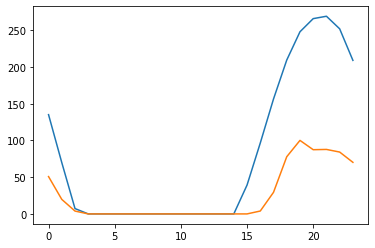

126.38846358843209


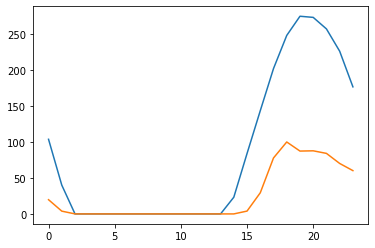

127.61432684642487


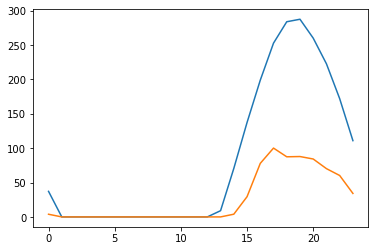

132.1798903767616


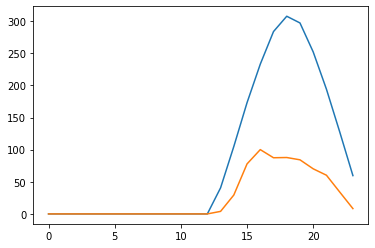

124.88495530886681


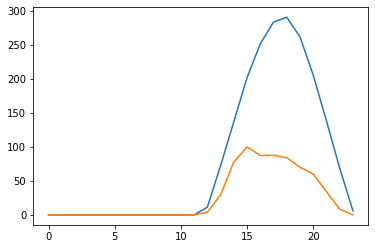

119.83831343375847


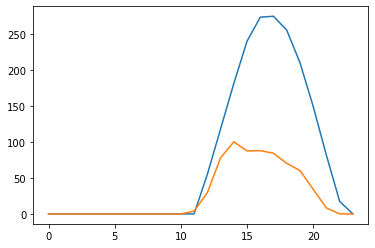

123.09672173418913


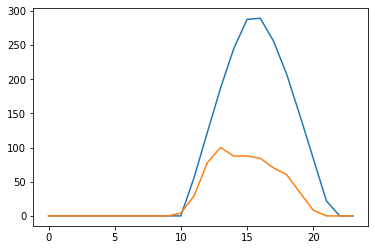

124.71319536308265


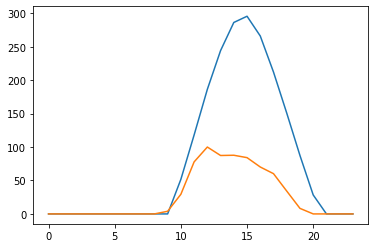

128.29128782662437


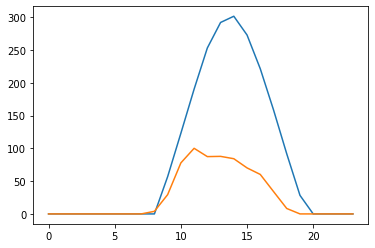

128.75319260823406


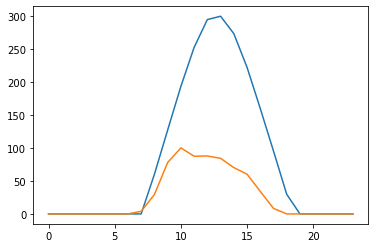

124.83500486043609


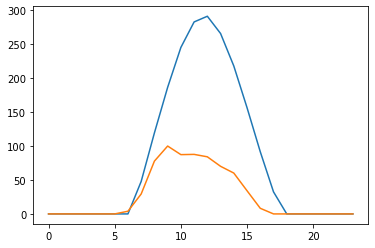

120.41120821624627


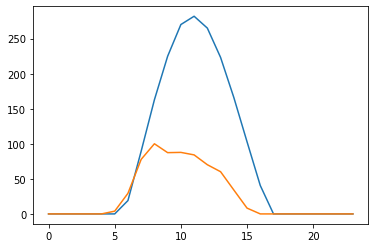

116.5833268628216


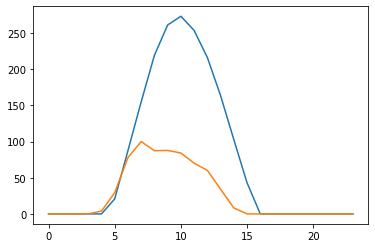

114.7415441822562


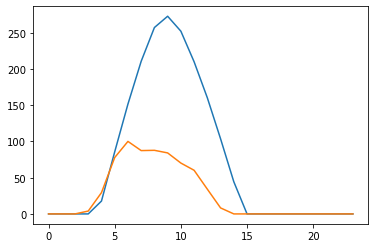

110.67811179564737


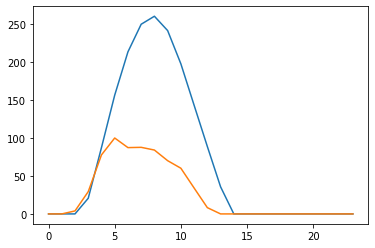

98.21653359256076


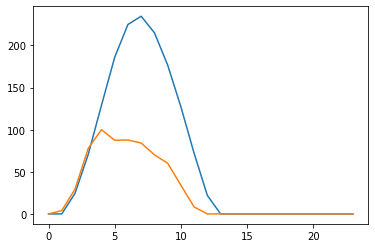

75.66777379357666


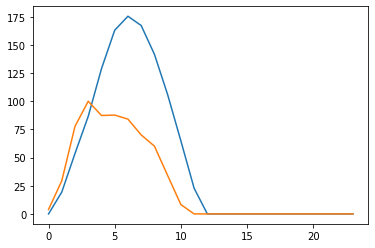

80.40627153024128


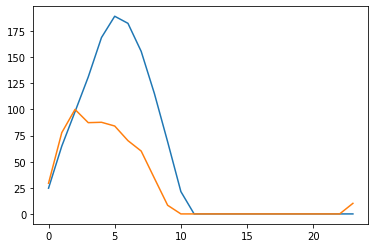

85.48316125318709


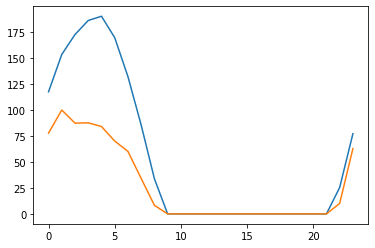

85.12271245046992


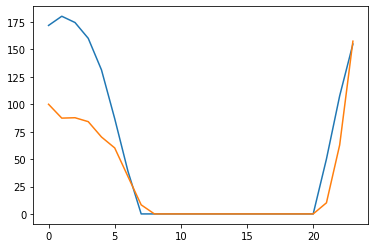

93.95244197417543


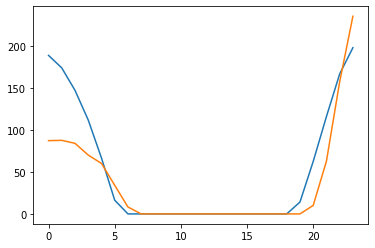

106.82324923587002


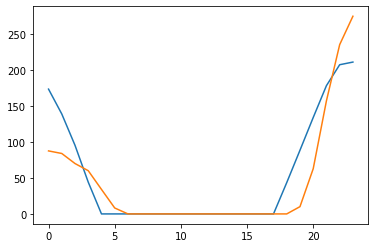

122.52258903652199


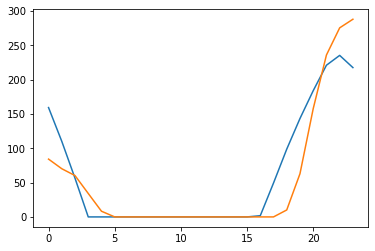

135.9774228288671


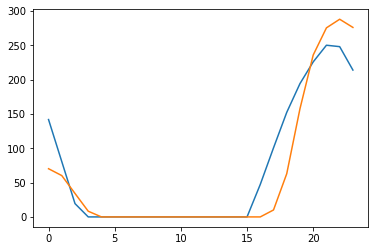

144.33667036828564


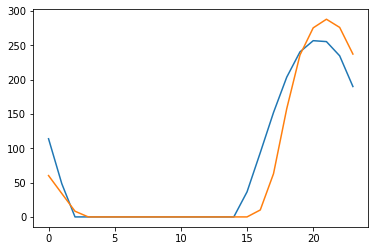

146.18557485351872


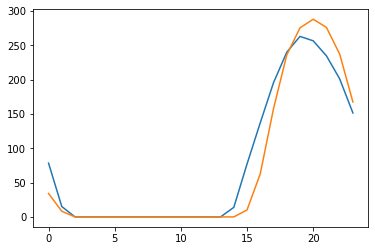

148.49390842353372


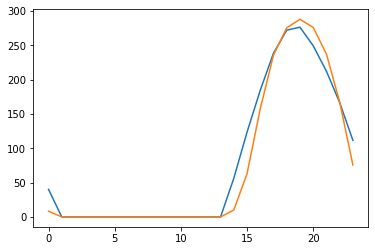

151.00894037397046


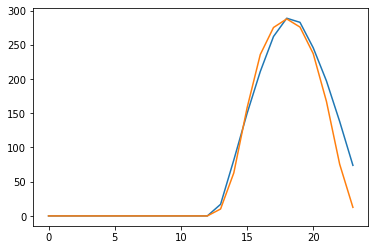

142.71236957572086


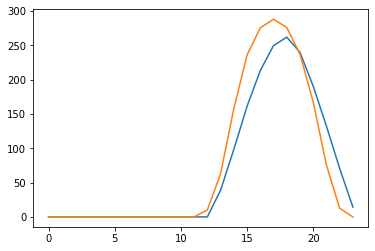

142.67948188273036


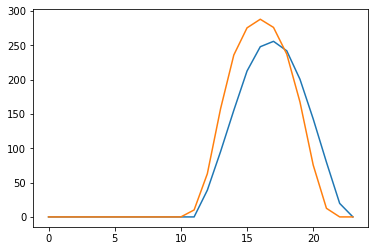

147.2060736486759


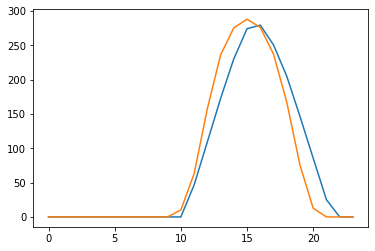

149.9297731791655


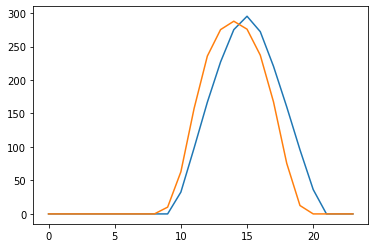

151.222713008333


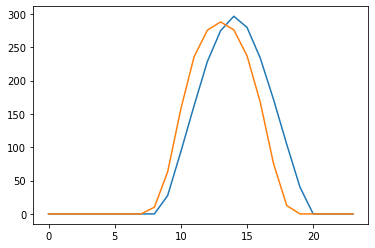

152.0930710158241


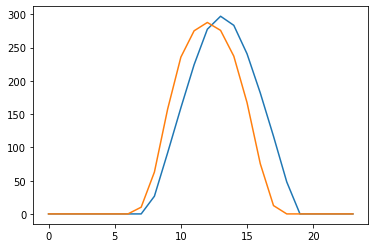

151.88648489119743


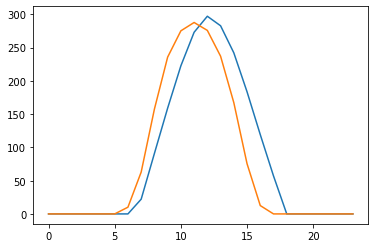

151.16151549454915


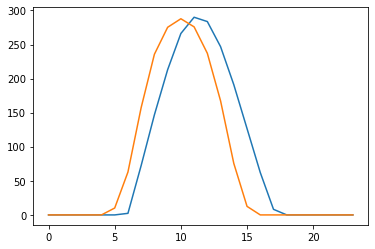

149.85723441591165


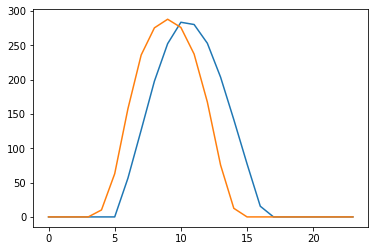

148.7681682011615


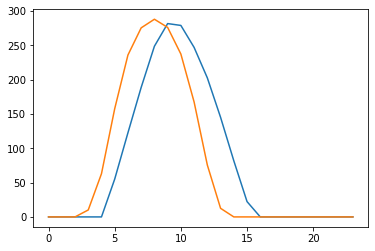

147.54197745137822


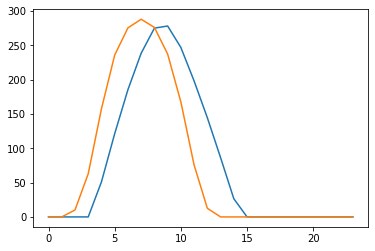

146.12586232801078


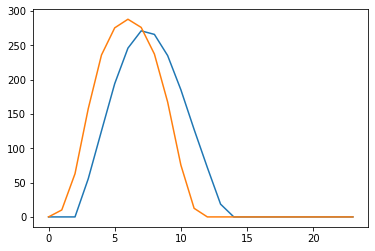

135.83730651067745


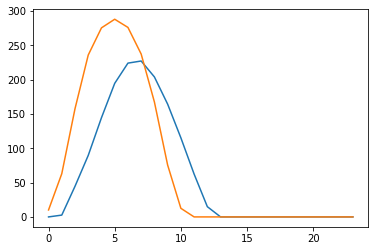

139.95812147943283


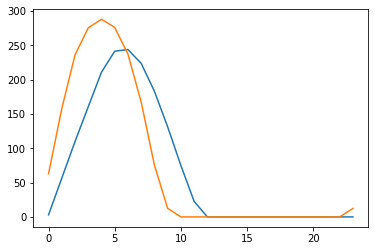

141.63481078342474


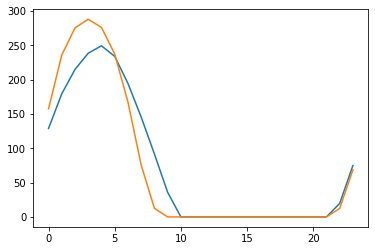

143.43549544963847


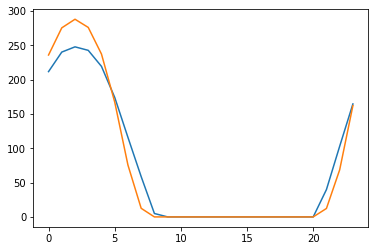

146.15484624593995


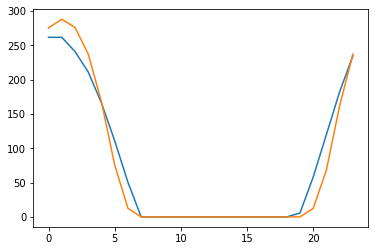

151.02203014578402


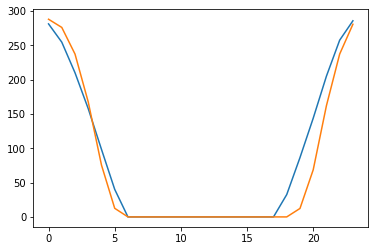

157.64604523297655


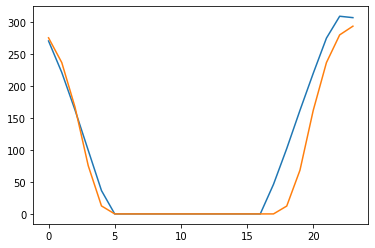

160.77003329101402


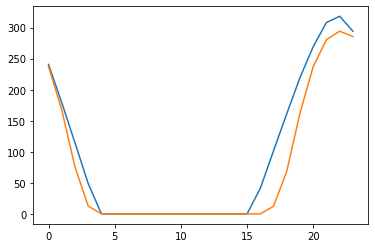

160.6783331076733


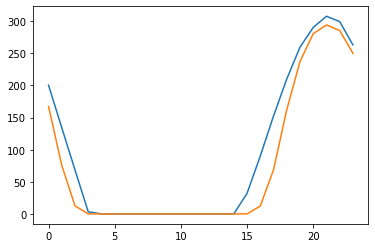

161.58521215707384


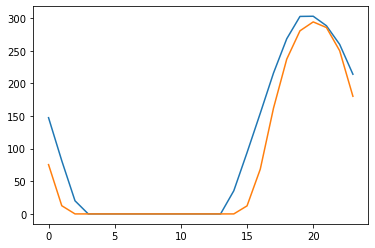

164.57242422382313


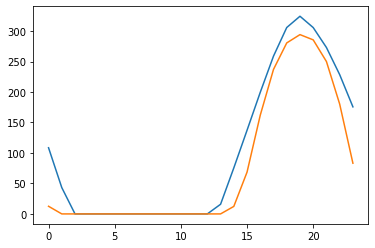

168.97551769610803


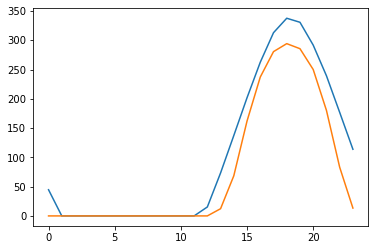

168.1329640708844


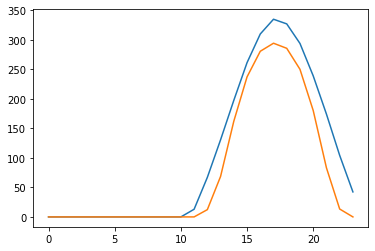

169.79122320684087


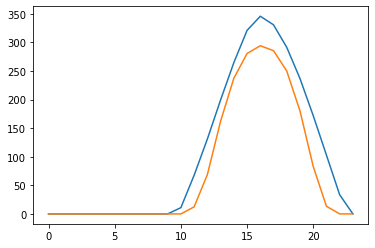

169.58260338523664


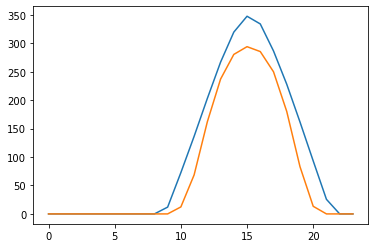

167.72070945045158


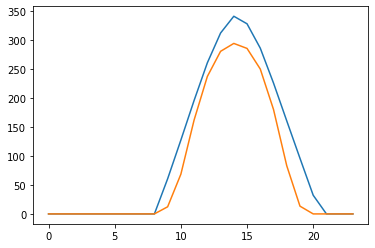

167.00001962009108


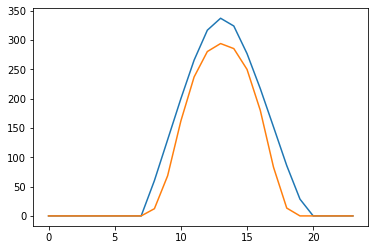

168.7828569205834


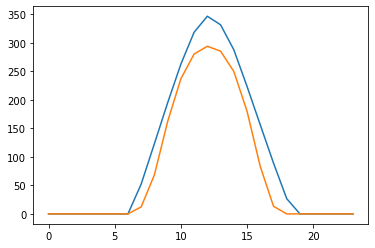

169.09469585899046


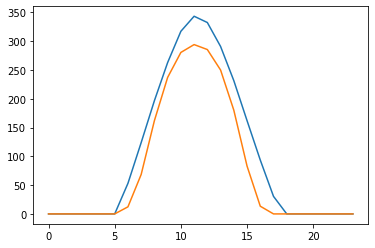

168.87746103228085


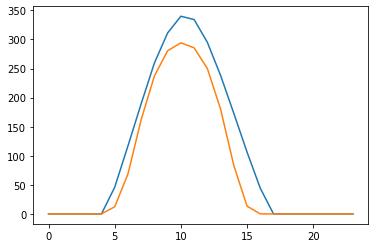

169.1451139500506


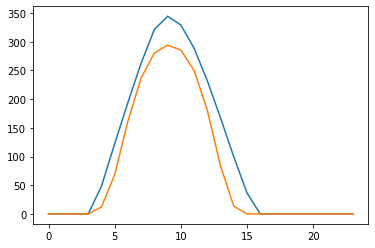

165.72149882799562


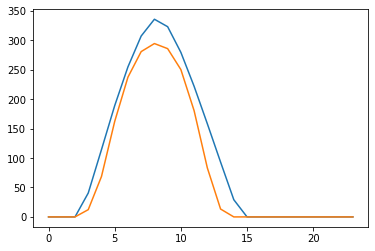

162.32636183914218


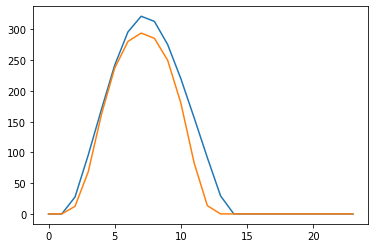

154.78615440650896


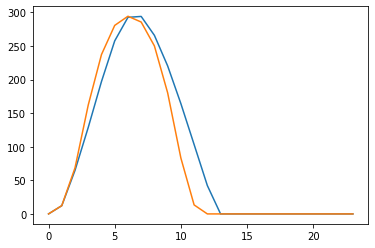

140.00759449164042


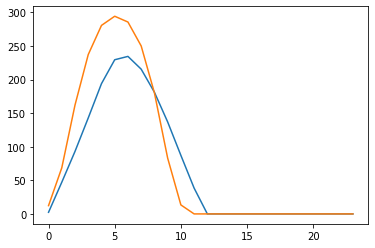

142.4703434665814


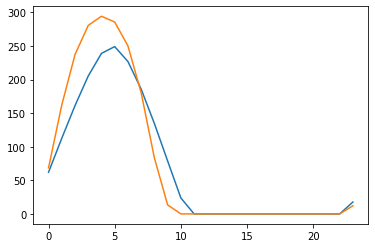

137.84082673362948


KeyboardInterrupt: 

In [56]:
for i in range(len(trainX)):
    predicted = model.predict(trainX[i].reshape(1, 168, 1))[0]
    actual = trainY[i]
    error = actual-predicted
    print(math.sqrt(np.mean(np.square(error))))
    plt.plot(predicted)
    plt.plot(actual)
    plt.show()

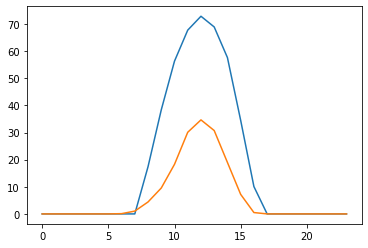

In [54]:
import matplotlib.pyplot as plt

predicted = model.predict(trainX[1].reshape(1, 168, 1))[0]
actual = trainY[1]

plt.plot(predicted)
plt.plot(actual)
plt.show()

In [52]:
predicted[0]

0.0